<div style="color:white;display:fill;border-radius:8px;
            background-color:#a7d5ed;font-size:170%;
            font-family:Nexa;letter-spacing:4.5px;">    
    <h1 style="padding:15px;color:black;text-align: center"> Rede Neural com Keras </h1> 
</div>

![](img/header.png?t=2021-04-09-00-57-05)

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> OBJETIVO </h1>    
</div>

O objetivo neste notebook é criação novas variáveis (feature) que possam ajudar na identificação de novos padrões, com a finalidade de bater a baseline estabelecida no [notebook](https://www.kaggle.com/code/rogeriodelfim/tps-nov-2022-01-eda-baseline), para isso vamos os seguintes passos: 


<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

## 1.1. Instalações

In [1]:
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    !pip install --q catboost
    !pip install --q colorama
    !pip install --q tensorflow
    !pip install --q wandb 
    
    from google.colab import drive
    drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [2]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
import multiprocessing
import glob
import glob
import pickle
import scipy.optimize 
import scipy.special

In [3]:
import pandas                    as pd
import numpy                     as np
import matplotlib.pyplot         as plt 
import seaborn                   as sns
import joblib                    as jb
#import scipy.stats               as stats
#import plotly.express            as px
#import xgboost                   as xgb
import lightgbm                  as lgb
#import scikitplot                as skplt
import sklearn.feature_selection as fs
#import category_encoders         as ce

In [4]:
from matplotlib.axes._axes     import _log as matplotlib_axes_logger
from sklearn.model_selection   import train_test_split, StratifiedKFold #, KFold, , cross_val_score
from sklearn.preprocessing     import StandardScaler #,  OneHotEncoder, KBinsDiscretizer, MaxAbsScaler
from sklearn.metrics           import roc_auc_score, f1_score, log_loss, roc_curve, auc
from sklearn.metrics           import classification_report, confusion_matrix
# from scipy.stats               import spearmanr
# from sklearn.impute            import SimpleImputer

In [5]:
from sklearn                    import set_config 
from sklearn.utils              import estimator_html_repr 
from IPython.core.display       import HTML , display_html 
from imblearn.pipeline          import Pipeline
from sklearn.compose            import ColumnTransformer, make_column_transformer

In [6]:
#from tqdm.notebook             import tqdm, trange
from datetime                  import datetime
from colorama                  import Fore, Back, Style
#from sklearn.calibration       import CalibrationDisplay
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline          import Pipeline, make_pipeline, FeatureUnion
from sklearn.decomposition     import PCA
#from sklearn.mixture           import GaussianMixture, BayesianGaussianMixture
#from yellowbrick.cluster       import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
#from sklearn.cluster           import KMeans, AgglomerativeClustering

In [260]:
#from sklearn.linear_model      import LogisticRegression
#from sklearn.neighbors         import KNeighborsClassifier
#from sklearn.ensemble          import ExtraTreesClassifier   
#from sklearn.neighbors         import KNeighborsClassifier
#from sklearn.neural_network    import MLPClassifier
from sklearn.ensemble          import RandomForestClassifier
#from sklearn.ensemble          import AdaBoostClassifier
#from sklearn.ensemble          import HistGradientBoostingClassifier
#from sklearn.ensemble          import StackingClassifier

In [184]:
# Tensorflow
import wandb
import graphviz 
# import math

import tensorflow as tf
  
from sklearn.tree           import export_graphviz
from tensorflow             import keras
from keras                  import backend as K
from tensorflow.keras       import layers, callbacks, Input
from tensorflow.keras.utils import plot_model
from wandb.keras            import WandbCallback
from sklearn.metrics        import log_loss, accuracy_score

from tensorflow.keras.callbacks import ReduceLROnPlateau#, LearningRateScheduler, EarlyStopping

from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, BatchNormalization, Embedding, Conv1D, Flatten
from tensorflow.keras.models import Model, load_model

#from tensorflow import keras
#from tensorflow.keras import layers


#from sklearn.utils import class_weight as cw 

#from kaggle_secrets import UserSecretsClient

#user_secrets = UserSecretsClient()
#wandb_auth = user_secrets.get_secret("wandb_tps_nov22")
#!wandb login $wandb_auth


In [256]:
from optuna.samplers               import TPESampler
from optuna.visualization          import plot_edf
from optuna.visualization          import plot_optimization_history
from optuna.visualization          import plot_parallel_coordinate
from optuna.visualization          import plot_param_importances
from optuna.visualization          import plot_slice
from optuna.visualization          import plot_intermediate_values
from optuna.visualization          import plot_contour
from optuna.pruners                import MedianPruner
from optuna.pruners                import BasePruner
from optuna.trial._state           import TrialState

<p style="border-bottom: 2px solid #256B5D"/></p>

## 1.3. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [215]:
def plot_hist(hist):
    history_df = pd.DataFrame(hist.history)
    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(history_df['loss'],label='Train')
    plt.plot(history_df['val_loss'],label='Valid')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history_df['auc'],label='Train')
    plt.plot(history_df['val_auc'],label='Valid')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [216]:
def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):                    
                        os.remove(os.path.join(raiz, arquivo))                        

In [232]:
def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_, y_pred_test_submission_, 
                    score_, seed_, level_='1', target_='target', cutoff_value_=.6, gera_submission_=True, 
                    type_model_=1):    
    
    level       = 'n' + level_ + '/'
    model_name_ = model_name_.replace('.csv', '')
    
    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_)  + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_)  + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)  + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(y_pred_train_prob_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        
        if type_model_!=3:
            jb.dump(model_, path_name_model)
        #else: 
         #   model_.save(path_name_model)
                
        if gera_submission_:
            df_submission[target_] = y_pred_test_submission_
            df_submission.to_csv(path_ + 'Data/submission/' + model_name_+ '.csv', index=False)

In [218]:
def model_cv_fit_(models_, X_, y_, X_test_, path_, target_='pred', seed_=12359, print_report_=False, 
                 print_score_mdl_=True, n_splits_=5, create_sub_=False, var_th_=1.0e-03, level_='1',
                 save_ensamble_=True, clip_=1e-6, batch_size_=2048):
    
    cols        = []
    cols_score  = []
    df_history  = pd.DataFrame()
    num_model   = len(models_)+1
    oof_train   = np.zeros((len(X_), num_model))
    oof_test    = np.zeros((len(X_test_), num_model-1))
    score_mdl   = np.zeros(len(models_),)    
    kf          = StratifiedKFold(shuffle=True, n_splits=n_splits_, random_state=seed_)        
    X_ts        = scipy.special.logit(X_test_.clip(clip_, 1-clip_))
    
    for i, m in enumerate(models_):
        
        time_start  = datetime.now()        
        model       = m[1]
        type_model  = m[2]
        name_sub    = m[3]
        score_list  = []
        y_ts_pred   = 0 
        
        delete_files(name_sub)
        
        print()
        print('=> {} - {}'.format(m[0], seed_))
        print('='*73)

        for fold, (idx_tr, idx_va) in enumerate(kf.split(X_, y_)):
            
            time_fold_start = datetime.now()
            
            X_tr = scipy.special.logit(X_.iloc[idx_tr].clip(clip_, 1-clip_))
            X_va = scipy.special.logit(X_.iloc[idx_va].clip(clip_, 1-clip_))
            y_tr = y_.iloc[idx_tr]
            y_va = y_.iloc[idx_va]
            
            if type_model==1:
                model.fit(X_tr, y_tr)

            if type_model==2:
                model.fit(X_tr, y_tr, 
                          model__eval_set=[(X_va, y_va)], 
                          model__eval_metric ='binary_logloss', 
                          model__callbacks=[early_stopping(100)])
            
            if type_model==3:   

                X_ts_ = X_ts.copy()
               
                if m[6] is not None:
                    process = m[6].fit(X_tr, y_tr)                                    
                    X_tr    = process.transform(X_tr) 
                    X_va    = process.transform(X_va)  
                    X_ts_   = process.transform(X_ts_)
                    
                history = model.fit(X_tr, y_tr,
                                    epochs          = 1000, 
                                    batch_size      = batch_size_,
                                    callbacks       = [m[4], m[5]], # [early_stopping, plateau],
                                    validation_data = (X_va, y_va), 
                                    shuffle         = True, 
                                    verbose         = False)  
                
                y_va_pred  = model.predict(X_va, verbose=False)
                y_ts_pred += model.predict(X_ts_, verbose=False)/kf.n_splits         
                
                val_loss  = log_loss(y_va, y_va_pred)  
                val_f1    = f1_score(y_va,(y_va_pred>.5).astype(int))  

                _df          = pd.DataFrame(history.history)
                _df['fold']  = fold +1 
                _df['score'] = val_loss 
                df_history   = pd.concat([df_history, _df], axis=0)
                
                # Log metrics
                #run.log({'val_loss': val_loss, 'val_f1': val_f1})

            if type_model!=3:
                y_va_pred  = model.predict_proba(X_va)[:,1]
                y_ts_pred += model.predict_proba(X_ts)[:,1]/kf.n_splits                      
            
            logloss    = log_loss(y_va, y_va_pred) 
            f1         = f1_score(y_va, (y_va_pred>.5).astype(int))
            roc_auc    = roc_auc_score(y_va, (y_va_pred>.5).astype(int))            
            
            oof_train[idx_va, i]           = np.ravel(y_va_pred)
            oof_train[idx_va, num_model-1] = fold + 1
            
            time_fold_end = utility.diff(time_fold_start, datetime.now())
            
            msg = "Fold {} => L.Loss: {:2.5f} - F1-score: {:2.5f} - AUC:{:2.5f} - {}"            
            print(msg.format(fold+1,logloss,f1,roc_auc, time_fold_end))
            
            score_list.append(logloss)

        #tf.keras.backend.clear_session()
        
        oof_test[:,i] = np.ravel(y_ts_pred)
        score_mean    = np.mean(score_list).round(5)
        
        cols.append(m[0])
        cols_score.append(str.lower(m[0])+'_'+str(score_mean)+'_seed_{}'.format(seed_))
                
        if create_sub_:
            if target_ is None: target_=target
            name_sub = name_sub+'_{:2.5f}_folds_{}_seed_{}.csv'.format(score_mean, n_splits_, seed_)

            save_data_model(model_                  = model, 
                            model_name_             = name_sub, 
                            path_                   = path_, 
                            y_pred_train_prob_      = oof_train[:, i], 
                            y_pred_test_prob_       = oof_test[:,i], 
                            y_pred_test_submission_ = oof_test[:,i], 
                            score_                  = score_mean, 
                            seed_                   = seed_, 
                            level_                  = level_, 
                            target_                 = target_, 
                            cutoff_value_           = .1, 
                            gera_submission_        = True, 
                            type_model_             = type_model)  
        
        score_mdl[i] = score_mean
        
        time_end = utility.diff(time_start, datetime.now()) 
        
        print('-'*73)
        print(f'{Fore.GREEN}{Style.BRIGHT}[Fold Mean] L.Loss: {score_mean:.5f}{Style.RESET_ALL} - {time_end}') 
        print('='*73)
        
        if print_report_: 
            y_pred = (oof_train[:, i]>.5).astype(int)
            print()
            print(classification_report(y_, y_pred))
            print(confusion_matrix(y_, y_pred))    

        utility.free_gpu_cache()
           
    df_oof_tr         = pd.DataFrame(oof_train, columns=cols_score+['fold']) 
    df_oof_tr['fold'] = df_oof_tr['fold'].astype(int)
    df_oof_ts         = pd.DataFrame(oof_test, columns=cols_score) 
    df_score_mdl      = pd.DataFrame(score_mdl, columns= ['score'])
    
    df_score_mdl.index = cols    
    df_score_mdl       = df_score_mdl.sort_values(by='score',ascending=True)  
    
    if save_ensamble_:
        jb.dump(df_oof_tr, path_ + 'Data/pkl/df_pred_tr_n{}.pkl.z'.format(level_))
        jb.dump(df_oof_ts, path_ + 'Data/pkl/df_pred_ts_n{}.pkl.z'.format(level_));

    if print_score_mdl_: display(df_score_mdl)
        
    print()
    
    return df_oof_tr, df_oof_ts, df_score_mdl, df_history

In [254]:
def model_cv_fit(models_, X_, y_, X_test_, path_, target_='pred', seed_=12359, print_report_=False, 
                 print_score_mdl_=True, n_splits_=5, create_sub_=False, var_th_=1.0e-03, level_='1',
                 save_ensamble_=True, cli_=1e-6, batch_size_=2048, kf_=None):
    
    cols        = []
    cols_score  = []
    num_model   = len(models_)+1
    oof_train   = np.zeros((len(X_), num_model))
    score_mdl   = np.zeros(len(models_),)
    oof_test    = np.zeros((len(X_test_), num_model-1))
    kf          = StratifiedKFold(shuffle=True, n_splits=n_splits_, random_state=seed_)        
    X_ts        = scipy.special.logit(X_test_.clip(cli_, 1-cli_))
    df_history  = pd.DataFrame()
    
    if kf_ is not None:
        kf = kf_
    else:  
        jb.dump(kf, path_ + 'Data/pkl/StratifiedKFold_{}.pkl.z'.format(level_))

    for i, m in enumerate(models_):
        
        time_start  = datetime.now()        
        model       = m[1]
        type_model  = m[2]
        name_sub    = m[3]
        score_list  = []
        y_ts_pred   = 0 
        
        delete_files(name_sub)
        
        print()
        print('=> {} - {}'.format(m[0], seed_))
        print('='*73)

        for fold, (idx_tr, idx_va) in enumerate(kf.split(X_, y_)):
            
            time_fold_start = datetime.now()
            
            X_tr = scipy.special.logit(X_.iloc[idx_tr].clip(cli_, 1-cli_))
            X_va = scipy.special.logit(X_.iloc[idx_va].clip(cli_, 1-cli_))
            y_tr = y_.iloc[idx_tr]
            y_va = y_.iloc[idx_va]            
            
            if type_model==1:
                model.fit(X_tr, y_tr)

            if type_model==2:
                model.fit(X_tr, y_tr, 
                          model__eval_set=[(X_va, y_va)], 
                          model__eval_metric ='binary_logloss', 
                          model__callbacks=[early_stopping(100)])
            
            if type_model==3:   
                X_ts_ = X_ts.copy()    
                if m[6] is not None:
                    process = m[6].fit(X_tr, y_tr)                                    
                    X_tr    = process.transform(X_tr) 
                    X_va    = process.transform(X_va)  
                    X_ts_   = process.transform(X_ts_)
                    
                model, early_stopping, plateau=create_model(input_shape_=len(X_tr[0]), type_model_=m[7],seed_=fold+seed_)

                history = model.fit(X_tr, y_tr,
                                    epochs          = 1000, 
                                    batch_size      = batch_size_,
                                    callbacks       = [m[4], m[5]], # [early_stopping, plateau],
                                    validation_data = (X_va, y_va), 
                                    shuffle         = True, 
                                    verbose         = False)  
                
                y_va_pred  = model.predict(X_va, verbose=False)
                y_ts_pred += model.predict(X_ts_, verbose=False)/kf.n_splits         
                
                val_loss  = log_loss(y_va, y_va_pred)  
                val_f1    = f1_score(y_va,(y_va_pred>.5).astype(int))  

                _df          = pd.DataFrame(history.history)
                _df['model'] = m[3]
                _df['fold']  = fold+1 
                _df['score'] = val_loss 
                df_history   = pd.concat([df_history, _df], axis=0)
            
            if type_model!=3:
                y_va_pred  = model.predict_proba(X_va)[:,1]
                y_ts_pred += model.predict_proba(X_ts)[:,1]/kf.n_splits                      
                
            #y_va_pred  = model.predict_proba(X_va)[:,1]
            #y_ts_pred += model.predict_proba(X_ts)[:,1]/kf.n_splits                      
            logloss    = log_loss(y_va, y_va_pred) 
            f1         = f1_score(y_va, (y_va_pred>.5).astype(int))
            roc_auc    = roc_auc_score(y_va, (y_va_pred>.5).astype(int))            
            
            oof_train[idx_va, i]           = y_va_pred if type_model!=3 else np.ravel(y_va_pred)
            oof_train[idx_va, num_model-1] = fold + 1

            time_fold_end = utility.diff(time_fold_start, datetime.now())
            
            msg = "Fold {} => L.Loss: {:2.5f} - F1-score: {:2.5f} - AUC:{:2.5f} - {}"            
            print(msg.format(fold+1,logloss,f1,roc_auc, time_fold_end))
            
            score_list.append(logloss)

        oof_test[:,i] = y_ts_pred if type_model!=3  else np.ravel(y_ts_pred)
        score_mean    = np.mean(score_list).round(5)
        score_std     = np.std(score_list).round(5)
        
        cols.append(m[0])
        cols_score.append(str.lower(m[0])+'_'+str(score_mean)+'_seed_{}'.format(seed_))
                
        if create_sub_:
            if target_ is None: target_=target
            name_sub = name_sub+'_{:2.5f}_folds_{}_seed_{}.csv'.format(score_mean, n_splits_, seed_)

            save_data_model(model_                  = model, 
                            model_name_             = name_sub, 
                            path_                   = path_, 
                            y_pred_train_prob_      = oof_train[:, i], 
                            y_pred_test_prob_       = oof_test[:,i], 
                            y_pred_test_submission_ = oof_test[:,i], 
                            score_                  = score_mean, 
                            seed_                   = seed_, 
                            level_                  = level_, 
                            target_                 = target_, 
                            cutoff_value_           = .1, 
                            gera_submission_        = True, 
                            type_model_             = type_model)  
        
        score_mdl[i] = score_mean
        
        time_end = utility.diff(time_start, datetime.now()) 
        
        msg=f'{Fore.GREEN}{Style.BRIGHT}[Fold Mean] L.Loss: {score_mean:.5f} - \
             {score_std:.5f}+- {Style.RESET_ALL}-{time_end}'
        
        msg = '{}{}[Fold Mean] L.Loss: {:.5f} - {:.5f} +- {} - {}'.format(Fore.GREEN,
                                                                          Style.BRIGHT, 
                                                                          score_mean, score_std, 
                                                                          Style.RESET_ALL, 
                                                                          time_end)
        print('-'*73)
        print(msg) 
        print('='*73)
        
        if print_report_: 
            y_pred = (oof_train[:, i]>.5).astype(int)
            print()
            print(classification_report(y_, y_pred))
            print(confusion_matrix(y_, y_pred))    

        utility.free_gpu_cache()
    
    df_oof_tr         = pd.DataFrame(oof_train, columns=cols_score+['fold']) 
    df_oof_tr['fold'] = df_oof_tr['fold'].astype(int)
    df_oof_ts         = pd.DataFrame(oof_test, columns=cols_score) 
    df_score_mdl      = pd.DataFrame(score_mdl, columns= ['score'])
    
    df_score_mdl.index = cols    
    df_score_mdl       = df_score_mdl.sort_values(by='score',ascending=True)  
    
    df_score_mdl.index = cols    
    df_score_mdl       = df_score_mdl.sort_values(by='score',ascending=True)  
    
    if save_ensamble_:
        jb.dump(df_oof_tr, path_ + 'Data/pkl/df_pred_tr_tensor_f_n{}.pkl.z'.format(level_))
        jb.dump(df_oof_ts, path_ + 'Data/pkl/df_pred_ts_tensor_f_n{}.pkl.z'.format(level_));

    if print_score_mdl_: display(df_score_mdl)
        
    print()
    
    return df_oof_tr, df_oof_ts, df_score_mdl, df_history

In [257]:
#from operator import le

class TunningModels(nn.Module):

    from sklearn.preprocessing  import StandardScaler
    from sklearn.linear_model   import RidgeClassifier
    
    def __init__(self, name_model_, X_trn_, y_trn_, X_ts_, feature_=None, 
                 seed_=12359, scaler_=StandardScaler(), feature_bin_=None, 
                 target_='target', path_='', level_='1', sc_second_= None, 
                 n_splits_=5):
        
        super(TunningModels,self).__init__() 

        self.name_clf    = name_model
        self.X_trn       = X_trn_
        self.y_trn       = y_trn_
        self.X_ts        = X_ts_         
        self.feature     = feature_
        self.seed        = seed_
        self.scaler      = scaler_
        self.feature_bin = feature_bin_ 
        self.target      = target_
        self.path        = path_
        self.level       = level_
        self.sc_second   = sc_second_
        self.n_splits    = n_splits_

    def recover_prediction_first_level():
        
        preds_train1 = glob.glob("model/train/*.pkl.z")
        preds_test   = glob.glob("model/test/*.pkl.z")
        preds_val1   = glob.glob("model/valid/*.pkl.z")

        df_train1     = []
        scores_traint = dict()

        for p_name in preds_train1:    
            p    = jb.load(p_name)
            p_df = pd.DataFrame(p, columns=[p_name.replace('model/train\\', '')])    
            df_train1.append(p_df)    
            scores_traint[p_name] = f1_score(y_train1, (p_df>.5))

        df_val1     = [] 
        scores_val1 = dict()
        for p_name in preds_val1:    
            p    = jb.load(p_name)
            p_df = pd.DataFrame(p, columns=[p_name.replace('model/valid\\', '')])    
            df_val1.append(p_df)    
            scores_val1[p_name] = f1_score(y_val1, (p_df>.5))

        df_test     = [] 
        scores_test = dict()
        for p_name in preds_test:    
            p         = jb.load(p_name)
            p_df_test = pd.DataFrame(p, columns=[p_name.replace('model/test\\', '')])    
            df_test.append(p_df_test)

        df_train1 = pd.concat(df_train1, axis=1)
        df_val1   = pd.concat(df_val1, axis=1)
        df_test   = pd.concat(df_test, axis=1)

        return df_train1, df_val1, df_test.shape
        
    def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):
                        os.remove(os.path.join(raiz, arquivo))
 
    def logging_callback(study, frozen_trail):
        prev_best = study.user_attrs.get('prev_best', None)
        if prev_best != study.best_value:
            study.set_user_attr('prev_best', study.best_value)
            print(f"Trail {frozen_trail.number} finished with best value {frozen_trail.value}")

    def df_return_preds_tunning(model_name=None, level=1, target_='target', train_shape_row=0, test_shape_row=0): 

        if level==1: 
            level_ = 'n1'
        else: 
            if level==2:
                level_ = 'n2'
            else: 
                level_ = 'n3'

        paths = ['model/preds/test/'+ level_, 'model/preds/train/' + level_ ]    

        if model_name==None: 
            model_name=''

        for i, path in enumerate(paths): 

            name_file_pkl     = glob.glob(path + '/'+ model_name + '*.pkl.z')
            dic_preds_mdl_pkl = dict()

            for p_name in name_file_pkl:    
                y_model_pkl_name_col  = p_name.replace(path + '/', '').replace('.pkl.z','') 
                y_model_pkl           = jb.load(p_name)   

                if i==0:
                    if len(y_model_pkl)==test_shape_row:
                        dic_preds_mdl_pkl[y_model_pkl_name_col] = y_model_pkl

                if i==1:
                    if len(y_model_pkl)==train_shape_row:                        
                        dic_preds_mdl_pkl[y_model_pkl_name_col] = y_model_pkl

                gc.collect()

            if i==0:         
                X_test_pred_nivel_1 = pd.DataFrame(dic_preds_mdl_pkl)
            else:
                X_train_pred_nivel_1 = pd.DataFrame(dic_preds_mdl_pkl)

            gc.collect()

        X_train_pred_nivel_1[target_] = y

        return X_train_pred_nivel_1, X_test_pred_nivel_1
    
    def feature_select(mdl, feature=[], best_score=0):
    
        best_feature = ''

        for col in df_train1.columns:

            if col not in feature:
                Xtr  = df_train1[feature+[col]].copy()
                Xval = df_val1[feature+[col]].copy()                

                mdl.fit(Xtr, y_train1)

                p = mdl.predict(Xval)
                c = f1_score(y_val1, p)

                if c > best_score:
                    best_score = c
                    best_feature = col 

        return best_score, best_feature

    def permutation_test(mdl, feature_selected):

        dist = []

        for seed in range(100):

            Xtr  = df_train1[feature_selected].copy()
            Xval = df_val1[feature_selected].copy()

            np.random.seed(seed)

            Xtr['random']  = np.random.permutation(Xtr.iloc[:, -1].values)
            Xval['random'] = np.random.permutation(Xval.iloc[:, -1].values)

            mdl.fit(Xtr, y_train1)

            p = mdl.predict(Xval)
            c = f1_score(y_val1, p)

            dist.append(c)

        dist = np.array(dist)

        return dist.max()

    def feature_selected_model(model = RidgeClassifier(alpha=1.) ):
   
        score_feature, best_feature =  TunningModels.feature_select(model)
        print('Score: {:2.4f} => Feature: {}'. format(score_feature*100 , best_feature))

        feature_selected = []
        feature_selected.append(best_feature)

        loop = True

        while loop:

            best_score = TunningModels.permutation_test(model, feature_selected) 
            best_score = best_score + 1e-4

            score_feature, best_feature = TunningModels.feature_select(model, feature=feature_selected, best_score=best_score)
            

            if score_feature <= best_score:  
                print('Fim')
                loop= False
            else: 
                feature_selected.append(best_feature)
                print('Score: {:2.4f} => Feature: {}'. format(score_feature*100 , best_feature))

        return feature_selected
    
    def model_of_diversity_feature_group(model_, name_model, X_, y_, X_ts_, sc_, target_, feature_imp_num=5, 
                                         seed_=12359, path_=''):

        TunningModels.delete_files(name_model)

        cols_tr = X_.columns.to_list() 
        cols_ts = cols_tr.copy()
        cols_ts.remove('sample_weight')

        model = model_
        model = model.fit(X_[cols_ts], y_)

        df               = pd.DataFrame()
        df["feature"]    = cols_ts
        df["importance"] = model.feature_importances_

        df.sort_values("importance", axis=0, ascending=False, inplace=True)

        feature_import = df[:feature_imp_num]['feature'].to_list()

        for feature_imp in  feature_import:

            score_                =  0.09
            feature_best          = []
            feature               = X_ts_.columns            
            feature               = [s for s in feature if s not in feature_import]
            feature_number        = len(feature)
            feature_select_number = np.round(np.sqrt(len(feature)))
            feature_number_sample = int(np.round((feature_number/feature_select_number)))
            feature_sample        = []

            print('='*60)
            print(' Divercidade de Grupos de Features => ({})'.format(feature_imp))
            print('='*60)


            for i in  range(0,5):

                feature            = [s for s in feature if s not in feature_sample]
                feature_sample     = pd.Series(feature).sample(feature_number_sample).to_list() 
                name_model_xgb_div = name_model + 'group_fe_' + str(i)   

                feature_sample.append(feature_imp)
                feature_sample_ts = feature_sample.copy()

                feature_sample.append('sample_weight')

                model, score, df_feature_imp , df_preds_prob, y_pred_test = \
                TunningModels.train_model_cv(model_         = model_, 
                                             X_             = X_[feature_sample], 
                                             y_             = y_, 
                                             X_test_        = X_ts_[feature_sample_ts], 
                                             target_        = target_, 
                                             model_name_    = name_model_xgb_div, 
                                             sc_            = sc_, 
                                             sc_second_     = None, 
                                             n_splits_      = 3, 
                                             seed_          = seed_,
                                             path_          = path_, 
                                             save_predict_  = True, 
                                             level_         = '1', 
                                             print_result_  = False, 
                                             feature_       = None, 
                                             trial_         = None)

                if score >.59:
                    create = '*'
                else: 
                    create = ' '

                if score > score_:
                    # score_ = np.abs(score)
                    feature_best.append(feature)
                    print('Score: {:2.5f} =>{} Gr.Feature: {} {}'.format(score, create, i,''))

                gc.collect()

            print('')

        print('')
        print('FIM')
        print('')

    def model_of_diversity_feature_one_(model, name_model, seed_=12359):

        score_       =  0.09
        feature_best = []

        print('')
        print('Feature apenas uma')
        print('-'*20)

        TunningModels.delete_files(name_model)

        for feature in X_train.columns:

            name_model_xgb_div = name_model + feature 

            score = TunningModels.cross_valid(model       = model, 
                                              model_name_ = name_model_xgb_div, 
                                              X_          = X, 
                                              y_          = y, 
                                              X_test_     = X_test_sc_qt, 
                                              type_model  = 2, 
                                              feature     = feature,
                                              seed        = seed_, 
                                              tunning     = 1, 
                                              print_result= False, 
                                              n_splits    = 2
                                              )
            if score >.59:
                create = '*'
            else: 
                create = ' '

            if score > score_:
                score_ = np.abs(score)
                feature_best.append(feature)
                print('F1-score: {:2.5f} => {} feature: {}'.format(score, create, feature ))        

        print('')
        print('Feature dupla')
        print('-'*20)

        for feature in feature_best:

            for feature_ in feature_best:
                if feature != feature_:            
                    name_model_xgb_div = name_model + feature + '_' + feature_     

                    score = TunningModels.cross_valid(model       = model, 
                                                      model_name_ = name_model_xgb_div, 
                                                      X_          = X, 
                                                      y_          = y, 
                                                      X_test_     = X_test_sc_qt, 
                                                      type_model  = 2, 
                                                      feature     = [feature, feature_],
                                                      seed        = seed_, 
                                                      tunning     = 1, 
                                                      print_result= False, 
                                                      n_splits    = 2
                                                      )

                    if score >.59:
                        create = '*'
                    else: 
                        create = ' '

                    print('F1-score: {:.4f} => {} feature: {} | {}'.format(score*100, create,  feature, feature_ )) 

        print('')
        print('FIM')
        print('')
    


        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
        
    def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_,
                        y_pred_test_, score_, seed_, level_='1', target_='target'):
        
        level_ = 'n'+ level_ + '/'

        if score_>.6:          

            path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_)
            path_name_train = path_ + 'model/preds/train/' + level_ + model_name_.format(score_, seed_)
            path_name_test  = path_ + 'model/preds/test/'  + level_ + model_name_.format(score_, seed_)    
            path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)    

            jb.dump(y_pred_train_prob_, path_name_train)
            jb.dump(y_pred_test_prob_, path_name_test)
            jb.dump(model_, path_name_model)
            #jb.dump(pd.DataFrame([model_[0][0]['model'].get_params()]), path_name_param)   

            if score_>.7:                
                # Gerar o arquivo de submissão 
                df_submission[target_] = y_pred_test_
                name_file_sub =  path_ + 'Data/submission/tunning/' + model_name_.format(score_, seed_) + '.csv'
                df_submission.to_csv(name_file_sub, index = False)
                
    def diff(t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
        
    def feature_scaler(df_, scaler_=None, feature_bin_=None):
    
        if scaler_!=None: 
            
            #if feature_bin_!=None:
            #    disc = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='uniform')
            #    df_[feature_bin_] = disc.fit_transform(df_[feature_bin_])

            df_ = pd.DataFrame(scaler_.fit_transform(df_), columns=df_.columns)
    
        return df_

    def cross_valid(model_, model_name_, X_train_, y_train_, X_test_, fold_=5, target_='target', 
            path_='', level_='1', save_predict_=True, print_result_=True, seed_=12359, 
            feature_=None, feature_bin=None, scaler_=StandardScaler(), threshold=.5, print_report_=False 
            ):

        if feature_!=None: 
            X_train_ = X_train_[feature_]
            X_test_  = X_test_[feature_]

        #--------------------------------------------------------  
        # Escorpo de variáveis
        #--------------------------------------------------------

        time_pred_start    = datetime.now()
        preds_valid_f      = {}
        preds_test         = []
        total_auc          = []
        f_scores           = []
        auc_mean           = []
        f1_mean            = []
        lloss_mean         = []
        preds_test         = 0  
        pred_test_prob     = 0
        df_score_history   = pd.DataFrame()
        df_train_pred_fold = pd.DataFrame()
        df_pred_fold       = pd.DataFrame()
        random             = str(np.random.rand(1)[0]).replace('.','')
        model_name_        = model_name_ + '_score_{:2.5f}_{}_' + random + '.pkl.z'
        clf_name           = model_.__class__.__name__
        pri_result         = 92
        learning_rate      = model_.learning_rate         
        le                 = LabelEncoder()
        y_train_           = pd.DataFrame(le.fit_transform(y_train_), columns=[target_])
                                                   
        #--------------------------------------------------------  
        # Início do process de varilidação
        #--------------------------------------------------------
        have_observation=''

        if print_result_:
            num_parallel_tree = 1 #model_.get_params()['num_parallel_tree']
            learning_rate     = model_.learning_rate
            n_estimators      = model_.n_estimators * num_parallel_tree  
            max_depth         = model_.max_depth 
            msg               = 'Training model: {} - seed {} - n_estimators: {} - learning_rate: {} {:2.5f}'

            print('='*pri_result)            
            print(msg.format(clf_name, seed_, n_estimators, max_depth, learning_rate))
            print('='*pri_result)

        kf = StratifiedKFold(n_splits=fold_, random_state=42, shuffle=True)

        for fold,(idx_train, idx_val) in enumerate(kf.split(X_train_, y_train_, groups=y_train_)):

            time_fold_start = datetime.now()

            #--------------------------------------------------------  
            # Seleção dos dados
            #--------------------------------------------------------
            X_trn, X_val = X_train_.iloc[idx_train], X_train_.iloc[idx_val]
            y_trn, y_val = y_train_.iloc[idx_train], y_train_.iloc[idx_val]
            index_valid  = idx_train

             
        
            #--------------------------------------------------------  
            # Processamento
            #--------------------------------------------------------        
            X_trn = TunningModels.feature_scaler(X_trn, scaler_, feature_bin) 
            X_val = TunningModels.feature_scaler(X_val, scaler_, feature_bin) 

            #--------------------------------------------------------  
            # Modelo
            #--------------------------------------------------------
            model = model_.fit(X_trn, y_trn,
                               eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                               early_stopping_rounds = int(n_estimators*.1),
                               verbose               = False)

            #--------------------------------------------------------  
            # oof
            #--------------------------------------------------------
            preds_valid_proba = model.predict_proba(X_val, ntree_limit=model_.best_ntree_limit)
            y_pred_valid      = le.inverse_transform(np.argmax(preds_valid_proba, axis=1))
            
            #--------------------------------------------------------  
            # Obtenha os valores médios de cada fold para a previsão
            #--------------------------------------------------------  
            y_pred_test_prob = model.predict_proba(X_test_, ntree_limit=model_.best_ntree_limit)
            pred_test_prob  += np.max(y_pred_test_prob, axis=1) / fold_
            preds_test      += le.inverse_transform(np.argmax(y_pred_test_prob, axis=1)) / fold_

            #--------------------------------------------------------  
            # Métricas 
            #-------------------------------------------------------- 
            y_val = le.inverse_transform(y_val)
            acc   = metrics.accuracy_score(y_val, y_pred_valid)
            f1    = metrics.f1_score(y_val, y_pred_valid, average='weighted')
            prec  = metrics.precision_score(y_val, y_pred_valid, average='macro')

            #--------------------------------------------------------  
            # Concatenar validação e predição
            #--------------------------------------------------------        
            df_val_pred_fold = pd.DataFrame({'fold'     : fold+1,
                                             'index'    : idx_val, 
                                             'acc'      : acc, 
                                             'f1'       : f1,
                                             'prec'     : prec,                                              
                                             'target'   : y_val, 
                                             'y_pred'   : y_pred_valid, 
                                             'pred_val' : np.max(preds_valid_proba, axis=1)
                                             })

            df_train_pred_fold = pd.concat([df_train_pred_fold, df_val_pred_fold], axis=0)

            col_name        = le.inverse_transform(list(model.classes_))
            df_prob_temp    = pd.DataFrame(preds_valid_proba, columns=col_name)
            y_pred_pbro_max = df_prob_temp.max(axis=1)

            
            df_prob_temp['y_val']     = y_val
            df_prob_temp['y_pred']    = y_pred_valid 
            df_prob_temp['y_proba']   = np.max(preds_valid_proba, axis=1)            
            df_prob_temp['acc']       = acc   
            df_prob_temp['f1']        = f1 
            df_prob_temp['precision'] = prec              
            df_prob_temp['fold']      = fold+1
            df_prob_temp['index']     = idx_val   
            
            df_pred_fold = pd.concat([df_pred_fold, df_prob_temp], axis=0)
            
            del df_prob_temp
            
            #df_prob_temp['scaler']  = str(string_scaler)
            
            #preds_valid_proba = np.max(preds_valid_proba, axis=1)
            
            
            auc_mean.append(acc)   
            f1_mean.append(f1)    
            lloss_mean.append(prec) 

            #--------------------------------------------------------  
            # Print resultado Fold
            #--------------------------------------------------------
            if print_result_:
                msg = 'Fold: {} - ACC: {:2.5f} - F1-score: {:2.5f} - Precision: {:2.5f} - {}'
                time_fold_start_end = TunningModels.diff(time_fold_start, datetime.now())
                print(msg.format(fold+1, acc, f1, prec, time_fold_start_end))

            free_gpu_cache() 
        
        

        del X_trn, y_trn, X_val, y_val 

        df_train_pred_fold.sort_values("index", axis=0, ascending=True, inplace=True)

        #--------------------------------------------------------  
        # Salvar predição em disco
        #--------------------------------------------------------
        X_train_prob      = df_train_pred_fold['pred_val'].to_list()
        score             = np.mean(auc_mean)
        y_pred_test       = np.int32(preds_test)

        if save_predict_:
            TunningModels.save_data_model(model_             = model_, 
                                          model_name_        = model_name_, 
                                          path_              = path_, 
                                          y_pred_train_prob_ = X_train_prob, 
                                          y_pred_test_prob_  = pred_test_prob, 
                                          y_pred_test_       = y_pred_test,
                                          score_             = score, 
                                          seed_              = seed_, 
                                          level_             = level_, 
                                          target_            = target_
                                          )  

        #--------------------------------------------------------  
        # Print média dos Folds
        #--------------------------------------------------------
        time_pred_end = TunningModels.diff(time_pred_start, datetime.now())

        if print_result_:
            msg = '[Mean Fold]  ACC: {:.5f}(Std:{:.5f}) - F1: {:.5f} - Precision: {:.5f}  {}'        
            print('-'*pri_result)            
            print(msg.format(np.mean(auc_mean),np.std(auc_mean) , np.mean(f1_mean), np.mean(lloss_mean), time_pred_end))
            print('='*pri_result)
            print()
            
            if print_report_: 
                y_pred = df_train_pred_fold['y_pred']
                y_vl   = df_train_pred_fold['target']
                print(metrics.classification_report(y_vl, y_pred))

        free_gpu_cache() 

        return model, score, y_pred_test, df_pred_fold        
    
    def train_model_cv(model_, X_, y_, X_test_, target_, model_name_, sc_=MinMaxScaler(), sc_second_=None, 
                       n_splits_=5, seed_=12359, path_='', save_predict_=True, level_='1', 
                       print_result_=True, feature_=None, trial_=None):
            
        if feature_!=None: 
            X_      = X_[feature_]
            X_test_ = X_test_[feature_]
            
        taco              = 52 
        y_preds_test      = []
        y_preds_val_prob  = [] 
        y_preds_test_prob = []
        score             = []
        mdl               = []
        random            = str(np.random.rand(1)[0]).replace('.','')
        model_name_       = model_name_ + '_score_{:2.5f}_{}_' + random + '.pkl.z'    
        clf_name          = model_.__class__.__name__        
        df_preds_prob     = pd.DataFrame()
        df_feature_imp    = pd.DataFrame()
        time_start        = datetime.now()    
        n_estimators      = model_.get_params()['n_estimators']
        dub_scaler        = '=> Double Scaler' if sc_second_!=None else ''        
        lb                = LabelEncoder()
        y_                = pd.DataFrame(lb.fit_transform(y_), columns=[target_])
        col_prob          = y_[target_].sort_values().unique()
        vies              = np.array([0, 0, 0.03, 0.036, 0, 0, 0, 0, 0, 0]) 
        
        if print_result_:
            print('='*taco)
            print('{} - n_estimators: {} seed: {}  {}'.format(clf_name, n_estimators, seed_, dub_scaler))
            print('='*taco)

        folds = StratifiedKFold(n_splits=n_splits_, shuffle=True, random_state=seed_)

        for fold, (trn_idx, val_idx) in enumerate(folds.split(X_, y_)): #, groups=y

            time_fold_start = datetime.now()

            # ----------------------------------------------------
            # Separar dados para treino 
            # ----------------------------------------------------
            X_trn, X_val, sample_weight_train = X_.iloc[trn_idx], X_.iloc[val_idx], X_.iloc[trn_idx]['sample_weight']
            y_trn, y_val, sample_weight_valid = y_.iloc[trn_idx], y_.iloc[val_idx], X_.iloc[val_idx]['sample_weight'] 

            # ----------------------------------------------------
            # Processamento
            # ----------------------------------------------------        
            X_trn.drop('sample_weight', axis=1, inplace=True)
            X_val.drop('sample_weight', axis=1, inplace=True)

            X_trn = pd.DataFrame(sc_.fit_transform(X_trn), columns=X_trn.columns)
            X_val = pd.DataFrame(sc_.transform(X_val), columns=X_val.columns)
            X_tst = pd.DataFrame(sc_.transform(X_test_), columns=X_test_.columns)

            if sc_second_ is not None: 
                X_trn = pd.DataFrame(sc_second_.fit_transform(X_trn), columns=X_trn.columns)
                X_val = pd.DataFrame(sc_second_.transform(X_val), columns=X_val.columns)
                X_tst = pd.DataFrame(sc_second_.transform(X_tst), columns=X_tst.columns)

            # ---------------------------------------------------- 
            # Treinar o modelo 
            # ----------------------------------------------------     
            model_.fit(X_trn, 
                       y_trn,
                       sample_weight_train,
                       eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                       early_stopping_rounds = int(n_estimators*.1),
                       verbose               = False)

            # ---------------------------------------------------- 
            # Predição 
            # ----------------------------------------------------     
            #y_pred_val       = model_.predict(X_val, ntree_limit=model_.best_ntree_limit)    
            y_pred_val_prob  = model_.predict_proba(X_val, ntree_limit=model_.best_ntree_limit) 
            y_pred_test_prob = model_.predict_proba(X_tst, ntree_limit=model_.best_ntree_limit)

            y_pred_val_prob += vies         
            y_pred_val       = np.argmax(y_pred_val_prob, axis=1)

            y_preds_test.append(model_.predict(X_tst))
            y_preds_test_prob.append(y_pred_test_prob)

            df_prob_temp    = pd.DataFrame(y_pred_val_prob, columns=col_prob)
            y_pred_pbro_max = df_prob_temp.max(axis=1)

            df_prob_temp['fold']    = fold+1
            df_prob_temp['id']      = val_idx        
            df_prob_temp['y_val']   = y_val.values        
            df_prob_temp['y_pred']  = y_pred_val
            df_prob_temp['y_proba'] = np.max(y_pred_val_prob, axis=1)

            df_preds_prob = pd.concat([df_preds_prob, df_prob_temp], axis=0)

            # ---------------------------------------------------- 
            # Score 
            # ---------------------------------------------------- 
            acc = metrics.accuracy_score(y_val, y_pred_val, sample_weight=sample_weight_valid)
            score.append(acc)     

            # ---------------------------------------------------- 
            # Print resultado  
            # ---------------------------------------------------- 
            time_fold_end = diff(time_fold_start, datetime.now())        
            msg = '[Fold {}] ACC: {:2.5f} -  {}'
            
            if print_result_:
                print(msg.format(fold+1, acc, time_fold_end))

            # ---------------------------------------------------- 
            # Feature Importance
            # ----------------------------------------------------             
            feat_imp = pd.DataFrame(index   = X_trn.columns,
                                    data    = model_.feature_importances_,                            
                                    columns = ['fold_{}'.format(fold+1)])

            feat_imp['acc_'+str(fold+1)] = acc
            df_feature_imp = pd.concat([df_feature_imp, feat_imp], axis=1)

            # ---------------------------------------------------- 
            # Salva o modelo 
            # ---------------------------------------------------- 
            dic_model = {'scaler': sc_, 
                         'scaler_second': sc_second_,
                         'fold': fold+1,
                         'model': model_,                         
                         'vies': vies}

            mdl.append(dic_model)
            
            if trial_ is not None:
                trial_.report(acc, fold)
                if trial_.should_prune():
                    raise optuna.TrialPruned()

            time_end = diff(time_start, datetime.now())   

        acc_mean = np.mean(score) 
        acc_std  = np.std(score)
        
        df_preds_prob.sort_values("id", axis=0, ascending=True, inplace=True)

        # ------------------------------
        # Pós-processamento
        # referencia: https://www.kaggle.com/ambrosm/tpsfeb22-02-postprocessing-against-the-mutants
        # -------------------------------        
        y_proba  = sum(y_preds_test_prob) / len(y_preds_test_prob)
        y_proba += vies          

        y_pred_test       = np.argmax(y_proba, axis=1)
        y_pred_tuned      = lb.inverse_transform(y_pred_test)
        y_pred_tuned_prob = np.max(y_proba, axis=1)

        if save_predict_:                 
            TunningModels.save_data_model(model_             = mdl, 
                                          model_name_        = model_name_, 
                                          path_              = path_, 
                                          y_pred_train_prob_ = df_preds_prob['y_proba'], 
                                          y_pred_test_prob_  = y_pred_tuned_prob, 
                                          y_pred_test_       = y_pred_tuned,
                                          score_             = acc_mean, 
                                          seed_              = seed_, 
                                          level_             = level_, 
                                          target_            = target_
                                          ) 

        if print_result_:
            print('-'*taco)
            print('[Mean Fold] ACC: {:2.5f} std: {:2.5f} - {}'.format(acc_mean, acc_std, time_end))    
            print('='*taco)
            print()

        del X_trn, X_val, y_trn, y_val, feat_imp

        return mdl, acc_mean , df_feature_imp , df_preds_prob, y_pred_test
   
    def xgb(self, trial):
           
        # https://xgboost.readthedocs.io/en/latest/parameter.html
        # https://amangupta16.medium.com/xgboost-hyperparameters-explained-bb6ce580501d     
        
        eval_metric = ['mlogloss']
                
        params = {'objective'         : trial.suggest_categorical('objective', ['multi:softprob']), 
                  'booster'           : trial.suggest_categorical('booster', ['gbtree']),                 
                  'eval_metric'       : trial.suggest_categorical('eval_metric', ['mlogloss']), 
                  'use_label_encoder' : trial.suggest_categorical('use_label_encoder', ['False']),                   
                  'n_estimators'      : trial.suggest_int('n_estimators', 550, 1500, 100),                  
                  'max_depth'         : trial.suggest_int('max_depth', 5, 15),
                  'subsample'         : trial.suggest_discrete_uniform('subsample', .7, 1.0, .05), 
                  'learning_rate'     : trial.suggest_discrete_uniform('learning_rate', .01, 0.19, 0.01),
                  'reg_alpha'         : trial.suggest_int('reg_alpha', 1, 10), 
                  'reg_lambda'        : trial.suggest_int('reg_lambda', 5, 50),
                  'min_child_weight'  : trial.suggest_int('min_child_weight', 5, 25),  
                  'colsample_bytree'  : trial.suggest_float('colsample_bytree', 0.8, 1.0),   
                  'sampling_method'   : trial.suggest_categorical('sampling_method', ['gradient_based']), 
                 }
             
        if torch.cuda.is_available():           
            params.update({'predictor'  : trial.suggest_categorical('predictor', ['gpu_predictor']), 
                           'tree_method': trial.suggest_categorical('tree_method', ['gpu_hist']) , 
                           'gpu_id'     : trial.suggest_int('gpu_id', 0,0)})
                
        #pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
        
        mdl = xgb.XGBClassifier(**params) #, callbacks=[pruning_callback])
        
        _, score, _, _, _  = TunningModels.train_model_cv(model_        = mdl, 
                                                          X_            = self.X_trn, 
                                                          y_            = self.y_trn, 
                                                          X_test_       = self.X_ts, 
                                                          target_       = self.target, 
                                                          model_name_   = self.name_clf, 
                                                          sc_           = self.scaler, 
                                                          sc_second_    = self.sc_second, 
                                                          feature_      = self.feature,
                                                          n_splits_     = self.n_splits, 
                                                          seed_         = self.seed,
                                                          path_         = self.path,
                                                          level_        = self.level, 
                                                          trial_        = trial
                                                      )
            
        print('param = {}'.format(params))
        print()

        return score

NameError: name 'nn' is not defined

In [220]:
class Utility():
        
    def __init__(self):
        self.name_ =''
       
    def jupyter_setting():
    
        %matplotlib inline

        #os.environ["WANDB_SILENT"] = "true" 
        #plt.style.use('bmh') 
        #plt.rcParams['figure.figsize'] = [20,15]
        #plt.rcParams['font.size']      = 13

        matplotlib_axes_logger.setLevel('ERROR')

        pd.options.display.max_columns = None
        #pd.set_option('display.expand_frame_repr', False)

        warnings.filterwarnings(action='ignore')
        warnings.simplefilter('ignore')
        warnings.filterwarnings('ignore')
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        warnings.filterwarnings('ignore', category=FutureWarning)
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
        warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)
        warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

        pd.options.mode.chained_assignment = None 
        pd.set_option('display.max_rows', 200)
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.max_colwidth', 200)

        icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
        #sns.palplot(sns.color_palette(icecream))

        colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
              "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
              "lightskyblue", "sandybrown", "yellowgreen", "indianred",
              "lightsteelblue", "mediumorchid", "deepskyblue"]

        # Colors
        dark_red   = "#b20710"
        black      = "#221f1f"
        green      = "#009473"
        myred      = '#CD5C5C'
        myblue     = '#6495ED'
        mygreen    = '#90EE90'    
        color_cols = [myred, myblue,mygreen]

        return icecream, colors, color_cols

    def missing_zero_values_table(self, df):
        
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()
    
    def reduce_memory_usage(self, df, verbose=True):
    
        numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
        start_mem = df.memory_usage().sum() / 1024 ** 2

        for col in df.columns:

            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == "int":
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024 ** 2
        if verbose:
            print(
                "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                    end_mem, 100 * (start_mem - end_mem) / start_mem
                )
            )

        return df
    
    def graf_label(self, ax, total):

         for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            width, height = i.get_width() -.2 , i.get_height()

            x, y  = i.get_xy()  
            color = 'white'
            alt   = .5
            soma  = 0 

            if height < 70:
                color = 'black'
                alt   = 1
                soma  = 10

            ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                        (i.get_x()+.55*width, 
                         i.get_y()+soma + alt*height),
                         color   = color,
                         weight = 'bold',
                         size   = 14)
            
    def graf_bar(self, df, col, title, xlabel, ylabel, tol = 0):
    
        #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
        ax     = df    
        colors = col

        if tol == 0: 
            total  = sum(ax)
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           color   = colors, 
                           grid    = False)
        else:
            total  = tol     
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           figsize = (10,6),
                           color   = colors,
                           grid    = False)

        title   = title #+ ' \n'
        xlabel  = '\n ' + xlabel 
        ylabel  = ylabel + ' \n'

        ax.set_title(title  , fontsize=22)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)    

        min = [0,23000000]
        #ax.set_ylim(min)
        self.graf_label(ax, total)

    def correlation(self, df_, threshold_):
        col_corr    = set()  
        corr_matrix = df_.corr()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold_: 
                    colname = corr_matrix.columns[i]  
                    col_corr.add(colname)
                    
        return col_corr

    def __graf_fature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                         print_graf_=True, mask_=True, title_='', method_='pearson'):
        
        msg_title = '\n Correlação das variável {} -{} \n'.format(title_, 'method_')
        
        df = df_.copy().corr(method =method_).round(5)
        
        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_
            
            # Making a plot
            ax = sns.heatmap(df, annot=annot_, 
                             mask=mask, 
                             cmap="RdBu", 
                             annot_kws={"weight": "bold", "fontsize":13}                              
                            )

            ax.set_title(msg_title, fontsize=17)
            
            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal", style = 'whitegrid', palette= 'pastel')

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right", style = 'whitegrid', palette= 'pastel')
            
            
            
            plt.show();
            
            
            
        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
        
        #sns.set(style="darkgrid")
        plt.show();
                        
    def describe(self, df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']

        return m

    def graf_outlier(self, df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                   (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

    def diff(self, t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
    
    def free_gpu_cache(self):

        # https://www.kaggle.com/getting-started/140636
        #print("Initial GPU Usage")
        #gpu_usage()                             

        #cuda.select_device(0)
        #cuda.close()
        #cuda.select_device(0)   

        gc.collect()
        torch.cuda.empty_cache()

    def graf_eval(self):

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#

            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))


            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();

    def linear_fit_slope(self, y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope

    def linear_fit_intercept(self, y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept

    def cromer_v(self, x, y):
        cm       = pd.crosstab(x, y).to_numpy()        
        n        = cm.sum()
        r, k     = cm.shape
        chi2     = stats.chi2_contingency(cm)[0]
        chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
        kcorr    = k - (k-1) **2/(n-1)
        rcorr    = r - (r-1) **2/(n-1)    
        v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
        return v  

    def generate_category_table(self, data):

        cols    = data.select_dtypes(include='object').columns
        dataset = pd.DataFrame()

        for i in cols:
            corr = []
            for x in cols: 
                corr.append(self.cromer_v(data[i],data[x]))

            aux     = pd.DataFrame({i:corr})
            dataset = pd.concat([dataset, aux], axis=1) 

        return dataset.set_index(dataset.columns)
            
    def graf_feature_corr(self, df_, annot_=False, threshold_=.8, print_var_=False, 
                          print_graf_=True, mask_=True, title_='', method_='pearson'):

        df = df_.corr(method=method_).round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            sns.set(style="whitegrid", palette="pastel") 
            
            # Making a plot
            ax = sns.heatmap(df, annot = annot_, 
                             mask      = mask, 
                             cmap      = "RdBu", 
                             fmt       = ".2f",
                             annot_kws = {"weight": "bold", "fontsize":10}
                            )
            
            ax.set_title("\n Correlação das variável {} - {} \n".format(title_, method_.upper()), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")
            
            sns.set(style="darkgrid")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                
        return self.correlation(df_, threshold_)

    def plot_roc_curve(self, fpr, tpr, label=None):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "r-", label=label)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for FLAI 08')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.grid(True)

    def feature_engineering(self, df_):

        var_f27 = ''
        for col in df_['f_27']: 
            var_f27 +=col

        var_f27 = list(set(var_f27))
        var_f27.sort()

        df_["fe_f_27_unique"] = df_["f_27"].apply(lambda x: len(set(x)))

        for letra in var_f27:             
            df_['fe_' + letra.lower() + '_count'] = df2_train["f_27"].str.count(letra)

        return df_ 

    def identifies_outliers(self, df):

        cols_num = df.select_dtypes(np.number).columns

        for col in cols_num: 
            if col != 'unnamed':            
                Q1  = df[col].quantile(0.25)
                Q3  = df[col].quantile(0.75)
                IQR = Q3-Q1
                lowqe_bound=Q1 - 1.5 * IQR
                upper_bound=Q3 + 1.5 * IQR

                df['outliers_'+ col] = 0
                df['outliers_'+ col][(df[col]<=lowqe_bound)|(df[col]>=upper_bound)] = 1    

                df[col] = np.where(df[col] > df[col].quantile(0.95),
                                                df[col].median(),
                                                df[col])

    def evaluation(self, y_, predictions_, smape_base_=100):
        from sklearn import metrics
        mae   = metrics.mean_absolute_error(y_, predictions_)
        mse   = metrics.mean_squared_error(y_, predictions_)
        rmse  = metrics.mean_squared_error(y_, predictions_, squared=False) 
        mape  = metrics.mean_absolute_percentage_error(y_, predictions_)
        smape = self.smape(y_, predictions_)
        r2    = metrics.r2_score(y_, predictions_)    
        return rmse, mae, mse, mape, r2, smape
    
    def feature_statistic(self, df, feature_float, feature_cat=None):
        df['fe_mean']        = df[feature_float].mean(axis=1)   
        df['fe_std']         = df[feature_float].std(axis=1)   
        df['fe_median']      = df[feature_float].median(axis=1)   
        df['fe_var']         = df[feature_float].var(axis=1) 
        df['fe_min']         = df[feature_float].min(axis=1)   
        df['fe_max']         = df[feature_float].max(axis=1)   
        df['fe_skew']        = df[feature_float].skew(axis=1)   
        df['fe_quantile_25'] = df[feature_float].quantile(q=.25, axis=1)
        df['fe_quantile_50'] = df[feature_float].quantile(q=.5, axis=1)
        df['fe_quantile_75'] = df[feature_float].quantile(q=.75, axis=1)
        
        if feature_cat is not None:
            df['fe_dammy_count'] = df[feature_cat].sum(axis=1)   
        
        return df
    
    def gridSearchCV(self, model_, params_, X_train_, y_train_):
        """
        @param    model: sklearn estimator
        @param    params (dict): Dictionary of possible parameters

        @return   cv_results (DataFrame)
        """
        model_cv = GridSearchCV(model_, param_grid=params_, scoring='roc_auc', cv=5)
        model_cv.fit(X_train_, y_train_)
        cv_results = pd.DataFrame(model_cv.cv_results_)[['params', 'mean_test_score']]

        return cv_results
    
    def evaluate(self, model,X_train_, y_train_, X_test_, plotROC=False):

        model.fit(X_train_, y_train_)
        probs = model.predict_proba(X_train_)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(y_train_, preds)
        roc_auc = auc(fpr, tpr)
        print(f'AUC: {roc_auc:.4f}')

        rocDf = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':threshold})
        rocDf['tpr - fpr'] = rocDf.tpr - rocDf.fpr
        optimalThreshold = rocDf.threshold[rocDf['tpr - fpr'].idxmax()]

        y_pred = np.where(preds >= optimalThreshold, 1, 0)

        # Plot ROC AUC
        if plotROC:
            plt.title('Receiver Operating Characteristic')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()    

    def iqr_outliers(self, df,ft):

        q1  = df[ft].quantile(0.25)
        q3  = df[ft].quantile(0.75)
        iqr = q3-q1
        c   = 0 

        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr

        for i in range(len(df[ft])):
            if df[ft][i] > Upper_tail or df[ft][i] < Lower_tail:
                c+=1
        return c
    
    def outlier_create_feature_check(self, df_tr_, df_ts_, cols_=[], qt_inferior_=.25, qt_superior_=.75, 
                                     flg_ts_=True, input_limete_=False, verbose_=True):
    
        col_oltlier         = 'fe_outlier'
        df_tr_[col_oltlier] = 0 
        df_ts_[col_oltlier] = 0 

        for c in cols_:

            percentil25 = df_tr_[c].quantile(qt_inferior_)
            percentil75 = df_tr_[c].quantile(qt_superior_)

            iqr= percentil75 - percentil25 

            limite_inferior = percentil25 - 1.5 * iqr
            limite_superior = percentil75 + 1.5 * iqr

            df_tr_[col_oltlier][df_tr_[c]>limite_superior] = -1
            df_tr_[col_oltlier][df_tr_[c]<limite_inferior] = -1

            if input_limete_:
                df_tr_[c][df_tr_[c]>limite_superior] = limite_superior
                df_tr_[c][df_tr_[c]<limite_inferior] = limite_inferior

            if flg_ts_:
                df_ts_[col_oltlier][df_ts_[c]>limite_superior] = -1
                df_ts_[col_oltlier][df_ts_[c]<limite_inferior] = -1
                
                if input_limete_:
                    df_ts_[c][df_ts_[c]>limite_superior] = limite_superior
                    df_ts_[c][df_ts_[c]<limite_inferior] = limite_inferior

            if verbose_:
                print('Com a variável {}'.format(c))
                print(df_tr_[col_oltlier].value_counts())
                print()

        return df_tr_, df_ts_
        
    def calibrated_classifier_graf_model(self, mdl_list_, X_, y_, seed_=12359, figsize_=(10, 10), verbose_=False): 

        fig = plt.figure(1, figsize=figsize_)
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        
        if verbose_: ax2 = plt.subplot2grid((3, 1), (2, 0))

        ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")

        for name, mdl1 in mdl_list_:  
            model_pipeline  = Pipeline(steps=[
                ('preprocessor', preprocessor_1),
                #('sampler_over', over), 
                #('sampler_under', under),    
                ('variancethreshold', VarianceThreshold(threshold=0.1)),    
                ('selectpercentile', SelectPercentile(f_classif, percentile=90)), 
                ('model', mdl1)
                ])

            X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.5, random_state=seed_)

            model_calibrated = CalibratedClassifierCV(model_pipeline, method='isotonic', cv=2) 
            # method='isotonic' sigmoid

            model_calibrated.fit(X_train, y_train)

            if hasattr(model_calibrated, "predict_proba"):
                prob_pos = model_calibrated.predict_proba(X_val)[:, 1]
            else:  
                prob_pos = model_calibrated.decision_function(X_val)
                prob_pos = (prob_pos-prob_pos.min()) / (prob_pos.max()-prob_pos.min())

            score = brier_score_loss(y_val, prob_pos, pos_label=y_val.max())

            frac_of_pos, mean_pred_value = calibration_curve(y_val, prob_pos, n_bins=15, normalize=True)      

            ax1.plot(mean_pred_value, frac_of_pos, "s-", label="%s (%1.3f)" % (name, score))

            ax1.set_ylabel('Fração de positivos')
            ax1.set_ylim([-0.05, 1.05])
            ax1.legend(loc='upper left' )
            ax1.set_title('\nGráficos de calibração (curva de confiabilidade)\n', fontsize=18)

            if verbose_: 
                ax2.hist(prob_pos, range=(0, 1), bins=100, label=name, histtype="step", lw=2)    
                ax2.set_xlabel('Valor médio previsto')
                ax2.set_ylabel('Quantidade')
                ax2.legend(loc="upper left", ncol=1)

                plt.tight_layout()

                msg = 'AUC: {:2.5f} - F1: {:2.5f} - Perda: {:2.3f} -> {}'
                auc = roc_auc_score(y_val, prob_pos)
                f1  = f1_score(y_val, (prob_pos>.5).astype(int))
                print(msg.format(auc,f1, score, name))

        plt.show()

    def describe(df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
        
        return m
        
    def smape(self, a, f):
        return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

    def smape_(self, y_true, y_pred, base_=100.):
        denominator          = (np.abs(y_true)+np.abs(y_pred))/base_
        diff                 = np.abs(y_true-y_pred)/denominator
        diff[denominator==0] = 0.0
        return np.nanmean(diff)
    
    def smape_loss(y_true, y_pred):
        """SMAPE Loss"""
        return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200
    
    def calc_erro(y, y_pred, outros=True, ruturn_score=False):
        erro   = smape(y, y_pred)    
        
        
        if outros:        
            rmse = metrics.mean_squared_error(y, y_pred, squared=False)
            mape = metrics.mean_absolute_percentage_error(y, y_pred)
            mae  = metrics.mean_absolute_error(y, y_pred)
            
            print('RMSE : {:2.5f}'.format(rmse))
            print('MAE  : {:2.5f}'.format(mae))
            print('MAPE : {:2.5f}'.format(mape))
            
            
        if ruturn_score: 
            return erro
        else: 
            print('SMAPE: {:2.5f}'.format(erro))
            
    def graf_outlier(df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 
                    
    def graf_eval():

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#
            
            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))
                        
            
            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();
        
    def linear_fit_slope(y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope
        
    def linear_fit_intercept(y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept
    
    def create_fold(self, path_): 

        paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
                 'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
                 'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
                 'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
                 'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

        for p in paths:
            try:
                os.mkdir(path_+p)       
            except:
                #print('Erro ao criar pasta: {} '.format(path+p))
                pass 
        
utility = Utility()

In [14]:
icecream, colors, color_cols = Utility.jupyter_setting()
n_threads = multiprocessing.cpu_count()

# http://www.lps.usp.br/hae/apostila/densakeras-ead.pdf
os.environ['TF_CPP_MIN_LOG_LEVEL']      = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL']      = '1' 
os.environ['WANDB_SILENT']              = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL']      = '3'

## 1.4. Dataset

In [86]:
i = 11 
x = i if i==1 else 2 
x

2

In [15]:
path        =  '/content/drive/MyDrive/kaggle/Tabular Playground Series/2022/10 - Novembro/' if COLAB else ''      
path_data   = 'Data/'  
path_automl = 'automl/'
target      = 'label'
clip        = 1e-6

utility.create_fold(path)

### 1.4.4. Carrega dados

In [16]:
df1_train     = pd.read_csv(path + path_data + "train_labels.csv")
df_submission = pd.read_csv(path + path_data + "sample_submission.csv")

display(df1_train.head())
print(f" train data: Rows={df1_train.shape[0]}, Columns={df1_train.shape[1]}")
display(df_submission.head())

,id,label
0,0,0
1,1,1
2,2,1
3,3,1
4,4,0


 train data: Rows=20000, Columns=2


,id,pred
0,20000,0.640707
1,20001,0.636904
2,20002,0.392496
3,20003,0.588658
4,20004,0.783603


In [17]:
df_pred       = pd.DataFrame(np.zeros(40000), columns=['id'])
df_pred['id'] = df_pred.index

file_list = sorted(glob.glob(os.path.join(path + path_data, "submission_files/*.csv")))

In [18]:
%%time 

#for idx, file in enumerate(tqdm(file_list)):
#    df_pred[f'pred_{idx}'] = pd.read_csv(file)["pred"].to_numpy()  
    
#df_pred.set_index('id', inplace=True)
df_pred = jb.load(path + path_data + 'pkl/df_pred_nb_02_n1.pkl.z')

utility.free_gpu_cache()

df_pred.head()

CPU times: total: 16.8 s
Wall time: 24.3 s


,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15,pred_16,pred_17,pred_18,pred_19,pred_20,pred_21,pred_22,pred_23,pred_24,pred_25,pred_26,pred_27,pred_28,pred_29,pred_30,pred_31,pred_32,pred_33,pred_34,pred_35,pred_36,pred_37,pred_38,pred_39,pred_40,pred_41,pred_42,pred_43,pred_44,pred_45,pred_46,pred_47,pred_48,pred_49,pred_50,pred_51,pred_52,pred_53,pred_54,pred_55,pred_56,pred_57,pred_58,pred_59,pred_60,pred_61,pred_62,pred_63,pred_64,pred_65,pred_66,pred_67,pred_68,pred_69,pred_70,pred_71,pred_72,pred_73,pred_74,pred_75,pred_76,pred_77,pred_78,pred_79,pred_80,pred_81,pred_82,pred_83,pred_84,pred_85,pred_86,pred_87,pred_88,pred_89,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99,pred_100,pred_101,pred_102,pred_103,pred_104,pred_105,pred_106,pred_107,pred_108,pred_109,pred_110,pred_111,pred_112,pred_113,pred_114,pred_115,pred_116,pred_117,pred_118,pred_119,pred_120,pred_121,pred_122,pred_123,pred_124,pred_125,pred_126,pred_127,pred_128,pred_129,pred_130,pred_131,pred_132,pred_133,pred_134,pred_135,pred_136,pred_137,pred_138,pred_139,pred_140,pred_141,pred_142,pred_143,pred_144,pred_145,pred_146,pred_147,pred_148,pred_149,pred_150,pred_151,pred_152,pred_153,pred_154,pred_155,pred_156,pred_157,pred_158,pred_159,pred_160,pred_161,pred_162,pred_163,pred_164,pred_165,pred_166,pred_167,pred_168,pred_169,pred_170,pred_171,pred_172,pred_173,pred_174,pred_175,pred_176,pred_177,pred_178,pred_179,pred_180,pred_181,pred_182,pred_183,pred_184,pred_185,pred_186,pred_187,pred_188,pred_189,pred_190,pred_191,pred_192,pred_193,pred_194,pred_195,pred_196,pred_197,pred_198,pred_199,pred_200,pred_201,pred_202,pred_203,pred_204,pred_205,pred_206,pred_207,pred_208,pred_209,pred_210,pred_211,pred_212,pred_213,pred_214,pred_215,pred_216,pred_217,pred_218,pred_219,pred_220,pred_221,pred_222,pred_223,pred_224,pred_225,pred_226,pred_227,pred_228,pred_229,pred_230,pred_231,pred_232,pred_233,pred_234,pred_235,pred_236,pred_237,pred_238,pred_239,pred_240,pred_241,pred_242,pred_243,pred_244,pred_245,pred_246,pred_247,pred_248,pred_249,...,pred_4750,pred_4751,pred_4752,pred_4753,pred_4754,pred_4755,pred_4756,pred_4757,pred_4758,pred_4759,pred_4760,pred_4761,pred_4762,pred_4763,pred_4764,pred_4765,pred_4766,pred_4767,pred_4768,pred_4769,pred_4770,pred_4771,pred_4772,pred_4773,pred_4774,pred_4775,pred_4776,pred_4777,pred_4778,pred_4779,pred_4780,pred_4781,pred_4782,pred_4783,pred_4784,pred_4785,pred_4786,pred_4787,pred_4788,pred_4789,pred_4790,pred_4791,pred_4792,pred_4793,pred_4794,pred_4795,pred_4796,pred_4797,pred_4798,pred_4799,pred_4800,pred_4801,pred_4802,pred_4803,pred_4804,pred_4805,pred_4806,pred_4807,pred_4808,pred_4809,pred_4810,pred_4811,pred_4812,pred_4813,pred_4814,pred_4815,pred_4816,pred_4817,pred_4818,pred_4819,pred_4820,pred_4821,pred_4822,pred_4823,pred_4824,pred_4825,pred_4826,pred_4827,pred_4828,pred_4829,pred_4830,pred_4831,pred_4832,pred_4833,pred_4834,pred_4835,pred_4836,pred_4837,pred_4838,pred_4839,pred_4840,pred_4841,pred_4842,pred_4843,pred_4844,pred_4845,pred_4846,pred_4847,pred_4848,pred_4849,pred_4850,pred_4851,pred_4852,pred_4853,pred_4854,pred_4855,pred_4856,pred_4857,pred_4858,pred_4859,pred_4860,pred_4861,pred_4862,pred_4863,pred_4864,pred_4865,pred_4866,pred_4867,pred_4868,pred_4869,pred_4870,pred_4871,pred_4872,pred_4873,pred_4874,pred_4875,pred_4876,pred_4877,pred_4878,pred_4879,pred_4880,pred_4881,pred_4882,pred_4883,pred_4884,pred_4885,pred_4886,pred_4887,pred_4888,pred_4889,pred_4890,pred_4891,pred_4892,pred_4893,pred_4894,pred_4895,pred_4896,pred_4897,pred_4898,pred_4899,pred_4900,pred_4901,pred_4902,pred_4903,pred_4904,pred_4905,pred_4906,pred_4907,pred_4908,pred_4909,pred_4910,pred_4911,pred_4912,pred_4913,pred_4914,pred_4915,pred_4916,pred_4917,pred_4918,pred_4919,pred_4920,pred_4921,pred_4922,pred_4923,pred_4924,pred_4925,pred_4926,pred_4927,pred_4928,pred_4929,pred_4930,pred_4931,pred_4932,pred_4933,pred_4934,pred_

<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. Modelo linha de base  </h1>    
</div>

In [19]:
seed      = 12359
df2_train = df_pred[:df1_train.shape[0]].copy() 
df2_test  = df_pred[df1_train.shape[0]:].reset_index(drop=True)

df2_train.shape, df2_test.shape

((20000, 5000), (20000, 5000))

## 2.2. Split Treino/Teste

In [21]:
%%time 

X      = df2_train.copy()
y      = df1_train[target]
X_test = df2_test.copy()

X.shape, X_test.shape

CPU times: total: 391 ms
Wall time: 384 ms


((20000, 5000), (20000, 5000))

In [93]:
X_train, X_val, y_train, y_val = train_test_split(X[feature_selec_fsm], 
                                                  y, 
                                                  test_size    = .2, 
                                                  shuffle      = True, 
                                                  stratify     = y, 
                                                  random_state = seed
                                                 )

X_train.shape,  X_val.shape, X_test.shape

((16000, 1123), (4000, 1123), (20000, 5000))

In [94]:
X_val, X_ts_final, y_val, y_ts_final = train_test_split(X_val, y_val, 
                                                        test_size    = .1, 
                                                        shuffle      = True, 
                                                        stratify     = y_val, 
                                                        random_state = seed
                                                     )

X_val.shape, X_ts_final.shape

((3600, 1123), (400, 1123))

## 2.3. Modelo

Primeira coisa que vamos fazer é selecionar as melhores variáveis com o objeto do <b>SelectFromModel</b> do sklearn, vamos utilizar o melhor modelo do primeiro notebook, o <b>LGBM</b>.

### 2.3.1. Pipeline de treino

In [102]:
param_lgbm  = {
    'objective'         : 'binary',
    'metric'            : 'binary_logloss',
    'colsample_bytree'  : 0.5139258065278501,
    'learning_rate'     : 0.02,
    'max_depth'         : 6,
    'min_child_samples' : 219,
    'min_child_weight'  : 1e-05,
    'n_estimators'      : 300,
    'num_leaves'        : 128,
    'reg_alpha'         : 1,
    'reg_lambda'        : 0,
    'subsample'         : 0.8116483602711031,         
    #'device'            : 'gpu',    
    'random_state'      : seed}

model_lgbm = lgb.LGBMClassifier(**param_lgbm)

# Processamento
processar         = ('preprocessor', StandardScaler())
variancethreshold = ('variancethreshold', VarianceThreshold(threshold=1.0e-03)) 
selectpercentile  = ('selectpercentile', SelectPercentile(f_classif, percentile=98))

# Pipelne 
#model_pipeline_lgbm = Pipeline(steps=[processar, variancethreshold, selectpercentile, ('model', model_lgbm)])

# Pipelne 
pipeline_process = Pipeline(steps=[processar, variancethreshold, selectpercentile])

Vamos processar os dados de treino e teste para seleção de parametros da rede. 

In [ ]:
col = X_train.columns.to_list()

In [105]:
X_train_logit    = scipy.special.logit(X_train.clip(clip, 1-clip))
X_val_logit      = scipy.special.logit(X_val.clip(clip, 1-clip))
X_ts_final_logit = scipy.special.logit(X_ts_final.clip(clip, 1-clip))
X_test_logit     = scipy.special.logit(X_test[feature_selec_fsm].clip(clip, 1-clip))


pipeline_process.fit(X_train_logit, y_train)
                    
X_train_sc    = pipeline_process.transform(X_train_logit) 
X_val_sc      = pipeline_process.transform(X_val_logit)  
X_ts_final_sc = pipeline_process.transform(X_ts_final_logit) 
X_test_sc     = pipeline_process.transform(X_test_logit)

### 2.3.2. Seleção de variáveis

In [22]:
%%time 

_ = pd.DataFrame(processar[1].fit_transform(X.clip(clip, 1-clip)), columns=X.columns) 
mdl_fs_FromModel = fs.SelectFromModel(model_lgbm.fit(_, y), prefit=True)
X_fs = mdl_fs_FromModel.transform(_)

print("Dados originais com {} variáveis.".format(X.shape))
print("Foram selecionados {} variáveis.".format(X_fs.shape))
print()

del X_fs

Dados originais com (20000, 5000) variáveis.
Foram selecionados (20000, 1123) variáveis.

CPU times: total: 5min 10s
Wall time: 4min 37s


In [124]:
feature_selec_fsm = X.columns[mdl_fs_FromModel.get_support(indices=True)].to_list()
feature_all       = X.columns.to_list()
len(feature_selec_fsm)

1123

### 2.3.3. Estrutura da rede

In [ ]:
def create_model():
    reg1 = 1e-06
    reg2 = 1e-07 
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    UNITS = 128
    DROP = 0.3
    activation = tfa.activations.mish 
    
    inputs = Input(shape=(X.shape[1],))

    x0 = Dense(UNITS, kernel_regularizer=REG1, activation=activation)(inputs)
    x0 = Dropout(DROP)(x0)
    x0 = BatchNormalization()(x0)
    
    x1 = Dense(UNITS, kernel_regularizer=REG1,activation=activation,)(x0)
    x1 = Dropout(DROP)(x1)
    x1 = BatchNormalization()(x1)
    
    x = Concatenate()([x0,x1])
    x = Dense(1, kernel_regularizer=REG2,activation='sigmoid',)(x)
    
    model = Model(inputs, x)    
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=tf.keras.metrics.BinaryCrossentropy())
    
    return model

In [251]:
def create_model(input_shape_, activation_layer_='swish', activation_='sigmoid', 
                 learning_rate_=0.00001, dropout_=0.3, type_model_=4, seed_=12359):

    tf.random.set_seed(seed_)
    
    units      = int((input_shape_/2))
    reg_1      = 1e-06  #1e-04 
    reg_2      = 1e-05
    REG1 = tf.keras.regularizers.l2(reg_1)
    REG2 = tf.keras.regularizers.l2(reg_2)
    
    #activity_r = tf.keras.regularizers.L1L2(l1=1e-06, l2=1e-07)  
    activity_r = tf.keras.regularizers.L1L2(l1=1e-04, l2=1e-05)  
        
    if type_model_==1:
        model = keras.Sequential([    
            layers.BatchNormalization(input_shape=[input_shape_]), 
            layers.Dense(1024, activation=activation_layer_),
            layers.BatchNormalization(),
            layers.Dropout(0.6), 
            layers.Dense(512, activation=activation_layer_),    
            layers.Dropout(0.3),
            layers.Dense(512, activation=activation_layer_),    
            layers.Dropout(0.3),
            layers.Dense(256, activation=activation_layer_),
            layers.Dropout(0.3),
            layers.Dense(128, activation=activation_layer_),
            layers.Dropout(0.3),
            layers.Dense(64, activation=activation_layer_),
            #layers.Dropout(0.3),
            layers.Dropout(0.4),   ### 0.52014
            layers.Dense(32, activation=activation_layer_),        
            layers.Dropout(0.3),  ### 0.52014
            layers.Dense(1, activation=activation_)     
        ])
    
    if type_model_==2:
        model = keras.Sequential([    
            layers.BatchNormalization(input_shape=[input_shape_]), 
            layers.Dense(units, activation=activation_layer_, activity_regularizer=activity_r),
            layers.Dropout(0.6), 
            layers.BatchNormalization(),        
            layers.Dense(512, activation=activation_layer_),    
            layers.Dropout(0.3),    
            layers.BatchNormalization(),
            layers.Dense(256, activation=activation_layer_),
            layers.Dropout(0.3),
            layers.Dense(128, activation=activation_layer_),
            layers.Dropout(0.3),   
            layers.Dense(32, activation=activation_layer_),        
            layers.Dropout(0.3),   
            layers.Dense(1, activation=activation_)     
        ])
    
    if type_model_==3:
        model = keras.Sequential([    
            layers.BatchNormalization(input_shape=[input_shape_]), 
            layers.Dense(units, activation=activation_layer_, activity_regularizer=activity_r),
            layers.Dense(int(units/2), activation=activation_layer_),    
            layers.BatchNormalization(),
            layers.Dropout(dropout_),    
            layers.Dense(int(units/2/2), activation=activation_layer_),
            layers.Dropout(dropout_),
            layers.Dense(int(units/2/2/2), activation=activation_layer_),
            layers.Dropout(dropout_),   
            layers.Dense(int(units/2/2/2/2), activation=activation_layer_),        
            layers.Dropout(dropout_),   
            layers.Dense(1, activation=activation_, name='output')     
        ])

    if type_model_==4:
        
        inputs = Input(shape=(input_shape_,))

        x0 = Dense(units, kernel_regularizer=REG1, activation=activation_layer_)(inputs)
        x0 = Dropout(dropout_)(x0)
        x0 = BatchNormalization()(x0)

        x1 = Dense(units, kernel_regularizer=REG1,activation=activation_layer_,)(x0)
        x1 = Dropout(dropout_)(x1)
        x1 = BatchNormalization()(x1)

        x = Concatenate()([x0,x1])
        x = Dense(1, kernel_regularizer=REG1,activation=activation_,)(x)

        model = Model(inputs, x)
    
    model.compile(loss      = tf.keras.losses.BinaryCrossentropy(),     # binary_crossentropy  
                  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_), # 'adam',
                  metrics   = ['AUC']) 
    
    early_stopping = callbacks.EarlyStopping(monitor              = 'val_loss', 
                                             patience             = 20,  
                                             min_delta            = 0.0001,  
                                             mode                 = 'min',  
                                             baseline             = None,    
                                             restore_best_weights = True)
    
    plateau = ReduceLROnPlateau(monitor   = 'val_loss', 
                                factor    = 0.9, # .95
                                patience  = 20,
                                verbose   = False,
                                mode      = 'min')
    
    return model, early_stopping, plateau

### 2.3.4. Criar modelo 

In [252]:
model, early_stopping, plateau = create_model(input_shape_=len(X_train_sc[0]))
model.summary()

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_43 (InputLayer)          [(None, 1100)]       0           []                               
                                                                                                  
 dense_596 (Dense)              (None, 550)          605550      ['input_43[0][0]']               
                                                                                                  
 dropout_469 (Dropout)          (None, 550)          0           ['dense_596[0][0]']              
                                                                                                  
 batch_normalization_296 (Batch  (None, 550)         2200        ['dropout_469[0][0]']            
 Normalization)                                                                            

In [ ]:
model, early_stopping, plateau = create_model(input_shape_=len(X_train_sc[0]), learning_rate_=0.00001)
keras.utils.plot_model(model, show_shapes=True)

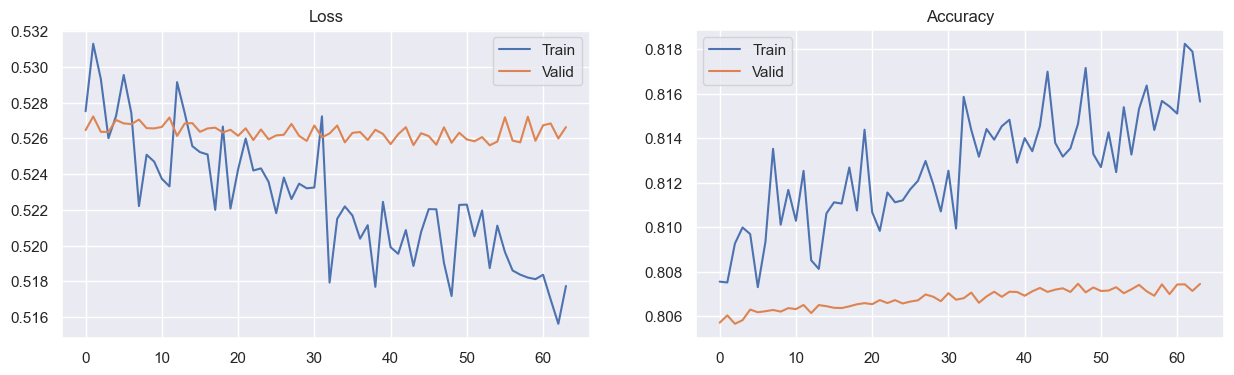

L.Loss: 0.49903 - AUC:0.82985

CPU times: total: 5min 45s
Wall time: 2min 17s


In [261]:
%%time 

history = model.fit(X_train_sc,
                    y_train,
                    epochs          = 1000, 
                    batch_size      = 256*2*2*2,
                    callbacks       = [early_stopping, plateau],
                    validation_data = (X_val_sc, y_val), 
                    shuffle         = True, 
                    verbose         = False)

tf.keras.backend.clear_session()
gc.collect()

plot_hist(history)

_lloss , _auc = model.evaluate(X_train_sc, y_train,  verbose=False)
print('L.Loss: {:2.5f} - AUC:{:2.5f}'.format(_lloss, _auc))
print()

# - https://www.kaggle.com/code/pourchot/tps-11-2022-neural-network
# - https://www.kaggle.com/code/teckmengwong/tps22novdummy 

# L.Loss: 0.50982 - AUC:0.83879

625/625 [==============================] - 6s 9ms/step


AUC: 0.74000 - F1-score: 0.74000 L.Loss: 0.51296


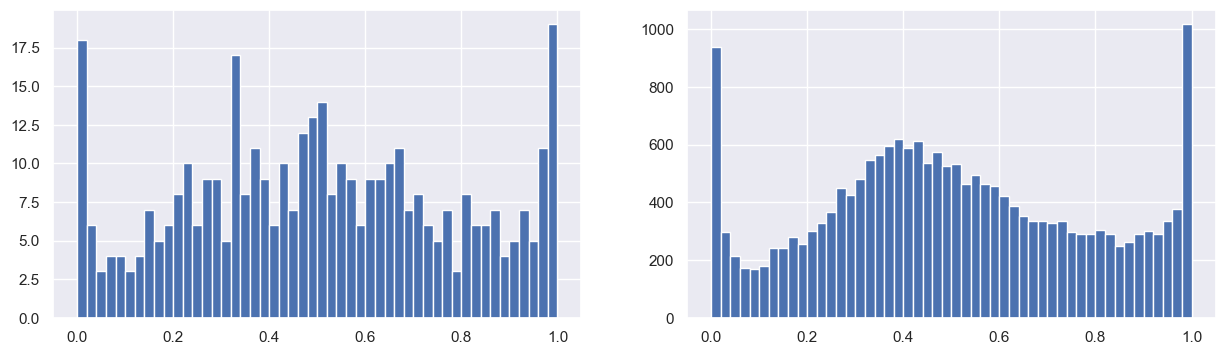

In [258]:
y_pred_val  = model.predict(X_ts_final_sc)
y_pred_test = model.predict(X_test_sc)

y_pred = (y_pred_val>.5).astype(int) 
print()
#print(classification_report(y_ts_final, y_pred))
#print(confusion_matrix(y_ts_final, y_pred))    

print()

# https://www.kaggle.com/code/mehrankazeminia/tps22aug-logisticr-lgbm-keras
f1    = f1_score(y_ts_final, y_pred)
auc   = roc_auc_score(y_ts_final, y_pred) 
lloss = log_loss(y_ts_final, y_pred_val)

print('AUC: {:2.5f} - F1-score: {:2.5f} L.Loss: {:2.5f}'.format(auc, f1, lloss))

sns.set()
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(y_pred_val, bins=50)

plt.subplot(1,2,2)
plt.hist(y_pred_test, bins=50);

In [ ]:
df_submission['pred'] = y_pred_test
df_submission.to_csv(path+path_data+'/submission/kara_20_score_{:2.5f}.csv'.format(lloss), index=False)

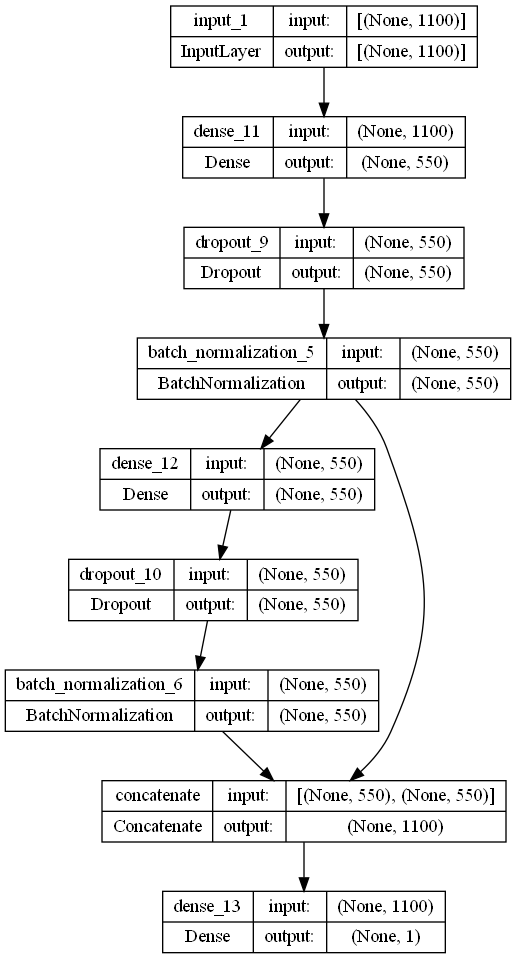

In [253]:
%%time


#model_tensorflow, early_stopping, plateau = create_model(input_shape_=1100)

kf     = jb.load(path+'Data/pkl/StratifiedKFold_2.pkl.z')
models = [('Tensorflow', model, 3, 'nb_03_n2_02_tensorflow', early_stopping, plateau, pipeline_process, 1), 
          ('Tensorflow', model, 3, 'nb_03_n2_03_tensorflow', early_stopping, plateau, pipeline_process, 2), 
          ('Tensorflow', model, 3, 'nb_03_n2_04_tensorflow', early_stopping, plateau, pipeline_process, 3),
          ('Tensorflow', model, 3, 'nb_03_n2_05_tensorflow', early_stopping, plateau, pipeline_process, 4)]

df_pred_tr, df_pred_ts, df_score_mdl, df_history = \
    model_cv_fit(models_       = models, 
                 X_            = X[feature_selec_fsm],
                 y_            = y, 
                 X_test_       = X_test[feature_selec_fsm],                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = 'pred',
                 create_sub_   = True, 
                 n_splits_     = 10,
                 print_report_ = True, 
                 save_ensamble_= True,
                 level_        = '2', 
                 kf_           = kf)

# 0.51976 - nb_03_n2_01_tensorflow_0.52772_folds_10_seed_12359.csv


=> Tensorflow - 12359
Fold 1 => L.Loss: 0.51951 - F1-score: 0.72177 - AUC:0.72900 - 0h 15m 21s
Fold 2 => L.Loss: 0.50174 - F1-score: 0.74317 - AUC:0.74600 - 0h 19m 34s
Fold 3 => L.Loss: 0.54221 - F1-score: 0.70480 - AUC:0.71100 - 0h 3m 49s
Fold 4 => L.Loss: 0.51962 - F1-score: 0.72699 - AUC:0.73450 - 0h 11m 47s
Fold 5 => L.Loss: 0.52711 - F1-score: 0.71392 - AUC:0.71950 - 0h 14m 4s
Fold 6 => L.Loss: 0.52651 - F1-score: 0.70036 - AUC:0.71250 - 0h 9m 10s
Fold 7 => L.Loss: 0.51841 - F1-score: 0.71270 - AUC:0.72750 - 0h 5m 43s
Fold 8 => L.Loss: 0.52190 - F1-score: 0.72251 - AUC:0.73500 - 0h 9m 46s
Fold 9 => L.Loss: 0.54299 - F1-score: 0.68958 - AUC:0.70200 - 0h 9m 41s
Fold 10 => L.Loss: 0.54554 - F1-score: 0.69597 - AUC:0.70600 - 0h 10m 25s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.52655 - 0.01295 +-  - 1h 49m 25s

              precision    recall  f1-score   support

           0       0.71      0.75      0.73     10000
           1 

,score
Tensorflow,0.52488
Tensorflow,0.52655
Tensorflow,0.52907
Tensorflow,NaN



CPU times: total: 23h 14min 42s
Wall time: 4h 14min 45s


In [ ]:
log_loss(y_ts_final, y_pred_val)

In [259]:
df_pred_tr

,tensorflow_0.52655_seed_12359,tensorflow_0.52488_seed_12359,tensorflow_nan_seed_12359,tensorflow_0.52907_seed_12359,fold
0,0.815910,0.797861,0.763539,0.748660,6
1,0.338811,0.369323,0.358346,0.309045,6
2,0.568062,0.572976,0.590848,0.445516,3
3,0.583380,0.566027,0.564726,0.662997,7
4,0.812788,0.856844,0.871899,0.857427,4
...,...,...,...,...,...
19995,0.732088,0.773188,0.737158,0.687048,6
19996,0.435541,0.424232,0.436139,0.536543,5
19997,0.828020,0.825476,0.821142,0.832304,1
19998,0.383894,0.402236,0.380624,0.343494,5


In [ ]:
keras.utils.plot_model(model_keras, show_shapes=True)

In [ ]:
%%time 

# Lista com os modelos para gerar as previsões 
models_n3 = [
    ('RForest', model_rf, 1, 'nb_02_n3_14_rf'), 
    #('XGB', model_xgb, 1, 'nb_02_n3_15_xgb'), 
    #('LGBM', model_lgbm, 1, 'nb_02_n3_16_lgbm'), 
    #('HBoosting', model_hbc, 1, 'nb_02_n3_17_hbc'), 
    #('LR', model_lr, 1, 'nb_02_n3_18_lr')
]
      
# Dataset para armazenar as previsões
df_pred_tr_n3   = pd.DataFrame() 
df_pred_ts_n3   = pd.DataFrame()
df_score_mdl_n3 = pd.DataFrame()

# Loop para treina cada modelo 
for mdl in models_n3: 
    
    # Lista com o nome de cada modelo
    cols = ['LR', 'KNN', 'MLP', 'XGB', 'ExTrees', 'LGBM', 'HBoosting', 'RForest']
    
    # remoção da colona, previsões do modelo, do treinamento. 
    cols.remove(mdl[0])
    
    # Chama uma função para treinar o modelo e retorna as previsões
    _tr_n3, _ts_n3, _score_mdl_n3 = \
        model_cv_fit(models_          = [mdl], 
                     X_               = df_tr[cols],
                     y_               = y, 
                     X_test_          = df_ts[cols],                  
                     path_            = path, 
                     seed_            = seed,
                     target_          = 'pred',
                     create_sub_      = True, 
                     n_splits_        = 10,
                     print_report_    = False, 
                     print_score_mdl_ = False, 
                     save_ensamble_   = True,
                     level_           = '3'
                    ) 
    
    # Armazeno as previsões para o próximo nível 
    df_pred_tr_n3   = pd.concat([df_pred_tr_n3, _tr_n3], axis=1)
    df_pred_ts_n3   = pd.concat([df_pred_ts_n3, _ts_n3], axis=1)
    df_score_mdl_n3 = pd.concat([df_score_mdl_n3, _score_mdl_n3]) 
    
del _tr_n3, _ts_n3, _score_mdl_n3 

df_score_mdl_n3.sort_values(by='score',ascending=True)  

# L.Loss: 0.52115 => 0.51405 -  nb_02_n3_14_rf_0.52115_folds_10_oof.csv.csv  

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Nas submissões, o modelo com seleção de variáveis teve o melhor desempenho com score de 0.51742 contra 0.51753, sendo assim, vamos utilizar a seleção de recurso para criar novas variáveis. 
    
</div>

<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. FEATURE ENGINEERING </h1>    
</div>


Nesta parte do processo vamos criar alguns variáveis com o intuito de ajudar o modelo a identificar novos padrões e consequentemente melhor o desempenho, como padrão vamos criar todas as variáveis com inicial <b>fe_</b>, a cada criação nova variável vamos treinar o modelo <u>LGBM</u> e identificar se as novas variáveis ajudam a encontrar novos padrões.

## 2.1. Gerar PCA
Nesta etapa vamos utilizar a PCA para gerar novas variáveis.

In [ ]:
len(feature_selec_fsm)

In [ ]:
X_21       = X[feature_selec_fsm].copy()
X_21       = X[feature_selec_fsm].copy()
X_test_21  = X_test[feature_selec_fsm].copy()

In [ ]:
%%time 

pca           = ('pca', PCA(random_state=seed))
pipeline_pca  = Pipeline(steps=[processar, pca])
Xt            = pipeline_pca.fit_transform(X_21)

## 2.1.1. Análise

In [ ]:
plt.figure(figsize=(20,7))

features = range(pipeline_pca['pca'].n_components_)
print(':', pipeline_pca['pca'].explained_variance_ratio_.cumsum()[:5].round(2))

plt.subplot(1,2,1)
plt.plot(pipeline_pca['pca'].explained_variance_ratio_.cumsum())
plt.title('Análise de componentes principais')
plt.xlabel('Componentes')
plt.ylabel('Razão de variância explicada cumulativa')

plt.subplot(1,2,2)
plt.bar(features[:15], pipeline_pca['pca'].explained_variance_[:15], color='lightskyblue')
plt.xlabel('PCA feature')
plt.ylabel('Variância')
plt.xticks(features[:15]);

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Podemos observar que as duas primeiras componentes explicam 83% da variância total dos dados, vamos dar uma olhada na distribuição dos dados:
    
</div>

In [ ]:
%%time 

n_components  = 2
pca_feats     = [f'fe_pca_{i}' for i in range(n_components)]
pca           = ('pca', PCA(n_components=n_components, random_state=seed))
pipeline_pca  = Pipeline(steps=[processar, pca])

pipeline_pca.fit(X_21)

X_21[pca_feats]      = pipeline_pca.fit_transform(X_21)
X_test_21[pca_feats] = pipeline_pca.fit_transform(X_test_21)

In [ ]:
plt.figure(figsize=(20,7))

_ = X_21.copy() 
_[target] = y 

for i,feature in enumerate(pca_feats):
    plt.subplot(1,2,i+1)
    sns.kdeplot(_[_[target]==0][feature],color='blue', alpha=0.5, label='0', shade=True)
    sns.kdeplot(_[_[target]==1][feature],color='teal', alpha=0.5, label='1', shade=True)  
    plt.xlabel(feature, fontsize=12)
    plt.legend()
         
plt.suptitle('Variável PCA 1 e PCA 2', fontsize=20)
plt.tight_layout(pad=3.0);

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Podemos observar no primeiro gráfico, áreas que não se sobrepÕe em relação as classes de classificações, quando olhamos para o segundo gráfico tem uma sobreposição das áreas das classes, isso torna a classificação dos modelos difícil, vamos dar uma olha na correlação dessas variáveis. 
    
</div>

In [ ]:
plt.figure(figsize=(7,4))
feature_corr = \
    utility.graf_feature_corr(df_         = _[pca_feats+[target]],                             
                              annot_      = True, 
                              threshold_  = .8, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = False, 
                              method_     = 'spearman');

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
No gráfico de correlação fica claro que a primeira PCA tem o maior porder preditivo <b>negativo</b>, isso pode ser um problema, pois a correlação negativo pode elevar o erro de predição,  em relação a segunda PCA tem um valor muito baixo.  
    
</div>

In [ ]:
X_21[pca_feats].describe()

In [ ]:
feature_drop = ['fe_pca_1']
X_21.drop(feature_drop, axis=1, inplace=True)
X_test_21.drop(feature_drop, axis=1, inplace=True)

In [ ]:
%%time

models = [('LGBM', model_pipeline_lgbm, 1, 'nb_02_n2_02_lgbm_nb_pca')]

df_pred_tr, df_pred_ts, df_score_mdl = \
    model_cv_fit(models_          = models, 
                 X_               = X_21,
                 y_               = y, 
                 X_test_          = X_test_21,                  
                 path_            = path, 
                 seed_            = seed,
                 target_          = 'pred',
                 create_sub_      = True, 
                 n_splits_        = 10,
                 print_report_    = False, 
                 print_score_mdl_ = False,
                 save_ensamble_   = False,
                 level_           = '2')

# L.Loss: 0.52108 /  L.Loss: 0.51999
# L.Loss: 0.52089 / L.Loss: 0.52004 

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
Não teve melhoria na submissão, mas vou permanecer com a variável.
    
</div>

## 2.2. Clustering

In [ ]:
X_22      = X_21.copy()
X_test_22 = X_test_21.copy()

### 2.2.1. Todas as variáveis

In [ ]:
feture_pca = X_22.columns.to_list()
feture_pca.remove('fe_pca_0')

In [ ]:
%%time 
sc1 = StandardScaler().fit(X_22[feture_pca])

_ = pd.DataFrame(sc1.fit_transform(X_22[feture_pca].copy()), columns=feture_pca)

f1, axs1 = plt.subplots(1,2,figsize=(20,6)) 

visualizer = KElbowVisualizer(KMeans(random_state=seed), k=(2,10), timings=False, ax=axs1[0])
visualizer.fit(_.values)
visualizer.finalize() 

k       = visualizer.elbow_value_
model_1 = KMeans(k, random_state=seed)
sv      = SilhouetteVisualizer(model_1, ax=axs1[1])

sv.fit(_)
sv.show();

### 2.2.2. Utilizando PCA

In [ ]:
%%time 

sc2 = StandardScaler() 
_   = pd.DataFrame(sc2.fit_transform(pd.DataFrame(X_21.copy()['fe_pca_0'])), columns=['fe_pca_0'])

f1, axs1 = plt.subplots(1,2,figsize=(20,6)) 

visualizer = KElbowVisualizer(KMeans(random_state=seed), k=(2,10), timings=False, ax=axs1[0])
visualizer.fit(_.values)
visualizer.finalize() 

k       = visualizer.elbow_value_
model_2 = KMeans(k, random_state=seed)
sv      = SilhouetteVisualizer(model_2, ax=axs1[1])

sv.fit(_)
sv.show();

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Utilizando PCA temos os clusters com melhor silhjouette e melhor distribuições em relação ao utilizar todas as variáveis para gera os clusters. 
    
Vamos gerar os clusters nos dados de treino e teste.
    
</div>

In [ ]:
%%time 

X_22['fe_cluster_kmeans']      = model_2.fit_predict(sc2.fit_transform(X_22))
X_test_22['fe_cluster_kmeans'] = model_2.fit_predict(sc2.fit_transform(X_test_22))

In [ ]:
X_22.filter(regex=r'fe').head()

In [ ]:
%%time 
model_bgmm = BayesianGaussianMixture(n_components    = k, 
                                     covariance_type = 'full', 
                                     n_init          = 3,
                                     init_params     = "kmeans",
                                     random_state    = seed) 

X_22['fe_cluster_bgmm_pca']      = model_bgmm.fit_predict(X_22[['fe_pca_0']])
X_test_22['fe_cluster_bgmm_pca'] = model_bgmm.fit_predict(X_test_22[['fe_pca_0']])

### 2.2.3. Gráfico de análise

In [ ]:
feature_sample = X_22.sample(27, axis='columns').columns.to_list()
row            = int(len(feature_sample)/3) + 1

f,ax = plt.subplots(figsize=(20,35))

for i, feature in enumerate(feature_sample):
    plt.subplot(row, 3 , i+1)
    sns.kdeplot(data=X_22, x=feature, hue="fe_cluster_kmeans", palette=sns.color_palette("hls", k));
    
utility.free_gpu_cache()

In [ ]:
f,ax = plt.subplots(figsize=(20,35))

for i, feature in enumerate(feature_sample):
    plt.subplot(row, 3 , i+1)
    sns.kdeplot(data=X_22, x=feature, hue="fe_cluster_bgmm_pca", palette=sns.color_palette("hls", k));
    
utility.free_gpu_cache()

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Podemos observar que os clusters conseguem fazer a separação dos dados, vamos dar uma olhada na correlação das variáveis criadas. 
    
</div>

In [ ]:
feature_corr = ['fe_pca_0','fe_cluster_kmeans', 'fe_cluster_bgmm_pca', target]

In [ ]:
plt.figure(figsize=(8,4))
_ = X_22.copy() 
_[target] = y

feature_corr = \
    utility.graf_feature_corr(df_         = _[feature_corr],
                              annot_      = True, 
                              threshold_  = .8, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = True, 
                              method_     = 'spearman');

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Temo uma alta correlação entre a PCA e o cluste gerado pelo kmeans, praticamente elas tem o mesmo pode preditivos em relação a variável alvo.

    

</div>

### 2.2.4. Criar dammy

In [ ]:
encoder = ce.OneHotEncoder(cols           = ['fe_cluster_bgmm_pca', 'fe_cluster_kmeans'],
                           handle_unknown = 'return_nan',
                           return_df      = True,
                           use_cat_names  = True)

encoder.fit(X_22)

_            = encoder.fit_transform(X_22)
_[target]    = y
feature_corr = _.filter(regex=r'fe_').columns.to_list()

plt.figure(figsize=(15,10))
feature_corr = \
    utility.graf_feature_corr(df_         = _[feature_corr+ [target]],
                              annot_      = True, 
                              threshold_  = .8, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = True, 
                              method_     = 'spearman');

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Me parece que criar variáveis <b>One Hot Encoding</b> da variável cluster seja  relevante, sendo assim, vamos implentar dentro de um pipeline a criação da variáveis dammies.   
    
</div>

In [ ]:
X_22.drop('fe_cluster_kmeans', axis=1, inplace=True)
X_test_22.drop('fe_cluster_kmeans', axis=1, inplace=True)

In [ ]:
X_22.filter(regex=r'fe_').head()

In [ ]:
X_test_22.filter(regex=r'fe_').head()

In [ ]:
X_22.shape, X_test_22.shape

### 2.2.5. Modelo sem dammy

In [ ]:
%%time

models = [('LGBM', model_pipeline_lgbm, 1, 'nb_02_n2_03_lgbm_nb_02_cluster_sem_dammy')]

df_pred_tr, df_pred_ts, df_score_mdl = \
    model_cv_fit(models_          = models, 
                 X_               = X_22,
                 y_               = y, 
                 X_test_          = X_test_22,                  
                 path_            = path, 
                 seed_           = seed,
                 target_          = 'pred',
                 create_sub_      = True, 
                 n_splits_        = 10,
                 print_report_    = False, 
                 print_score_mdl_ = False,
                 save_ensamble_   = False,
                 level_           = '2')

# L.Loss: 0.52108 / L.Loss: 0.51999
# L.Loss: 0.52089 / L.Loss: 0.52004 
# L.Loss: 0.52109 / L.Loss: 0.52037

In [ ]:
_ =  X_22.copy()
_['pred_proba'] =  y
_ = _.groupby('fe_cluster_bgmm_pca')['pred_proba'].mean()
f,ax = plt.subplots(figsize=(8,4))
sns.barplot(x=_.index, y=_.values, palette=sns.color_palette("hls", 6) );
ax.set_ylabel("Probabilidade média por cluster");
ax.set_ylim([0.,0.95]);

### 2.2.6. Modelo com dammy 

In [ ]:
param_lgbm  = {
    'objective'         : 'binary',
    'metric'            : 'binary_logloss',
    'colsample_bytree'  : 0.5139258065278501,
    'learning_rate'     : 0.02,
    'max_depth'         : 6,
    'min_child_samples' : 219,
    'min_child_weight'  : 1e-05,
    'n_estimators'      : 300,
    'num_leaves'        : 128,
    'reg_alpha'         : 1,
    'reg_lambda'        : 0,
    'subsample'         : 0.8116483602711031,         
    #'device'            : 'gpu',    
    'random_state'      : seed}

model_lgbm = lgb.LGBMClassifier(**param_lgbm)

# Processamento
feature_encoder_bin = X_22.filter(regex='fe_c').columns.to_list()
processar           = ('preprocessor', StandardScaler())
variancethreshold   = ('variancethreshold', VarianceThreshold(threshold=1.0e-03)) 
selectpercentile    = ('selectpercentile', SelectPercentile(f_classif, percentile=98))
selectKbest         = ('SelectKBest', SelectKBest(score_func=f_classif))
encoder_bin         = ('encoder_binary', ce.BinaryEncoder(cols=feature_encoder_bin, return_df=True))
mdl_lgbm            = ('model', model_lgbm)

# Pipelne 
model_pipeline_lgbm = Pipeline(steps=[encoder_bin, processar, variancethreshold, selectpercentile, mdl_lgbm])

In [ ]:

models = [('LGBM', model_pipeline_lgbm, 1, 'nb_02_n2_04_lgbm_nb_02_cluster_com_dammy')]

df_pred_tr, df_pred_ts, df_score_mdl = \
    model_cv_fit(models_          = models, 
                 X_               = X_22,
                 y_               = y, 
                 X_test_          = X_test_22,                  
                 path_            = path, 
                 seed_            = seed,
                 target_          = 'pred',
                 create_sub_      = True, 
                 n_splits_        = 10,
                 print_report_    = False, 
                 print_score_mdl_ = False,
                 save_ensamble_   = False,
                 level_           = '2')

# L.Loss: 0.52108 / L.Loss: 0.51999
# L.Loss: 0.52089 / L.Loss: 0.52004 
# L.Loss: 0.52109 / L.Loss: 0.52037

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

A transformação da variável cluster em dammy não melhou o desempenho do modelo.   
    
</div>

# 3. Modelagem

## 3.2. Definindo o pipeline

In [ ]:
# Paremetros 

params_xgb  = {
    'objective'        : 'binary:logistic',
    'eval_metric'      : 'logloss',
    'max_depth'        : 7,  
    'colsample_bytree' : 0.8, 
    'max_leaves'       : 10,    # 0.52463    
    'subsample'        : 0.95,  # 0.52460      
    
    #'lambda'           : 1.2,
    #'alpha'            : 0.9,   # 
    #'min_child_weight' : 1e-3,
    #'colsample_bylevel': 0.95,    
    # 'learning_rate'    : 1e-1,
     #'sampling_method'  : 'uniform',  # 0.52460   
    'n_jobs'           : -1,
    'seed'             : seed}

param_lgbm  = {
    'objective'         : 'binary',
    'metric'            : 'binary_logloss',
    'colsample_bytree'  : 0.5139258065278501,
    'learning_rate'     : 0.02,
    'max_depth'         : 6,
    'min_child_samples' : 219,
    'min_child_weight'  : 1e-05,
    'n_estimators'      : 300,
    'num_leaves'        : 128,
    'reg_alpha'         : 1,
    'reg_lambda'        : 0,
    'subsample'         : 0.8116483602711031,         
    #'device'            : 'gpu',    
    'random_state'      : seed}

param_rf    = {
    'class_weight'      : 'balanced', 
    'n_estimators'      : 100,
    'max_depth'         : 7,    # 0.52808
    'min_samples_split' : 5,    # 0.52804    
    'min_samples_leaf'  : 20,   #  0.52705
    'random_state'      : seed}

param_ext   = {
    'n_estimators'     : 500,
    'max_depth'        : 7, 
    'min_samples_leaf' : 12,         
    'n_jobs'           : -1,
    'random_state'     : seed}

param_lr    = {
    'max_iter'      : 1000, 
    'C'             : 0.0001, 
    'penalty'       : 'l2', 
    'fit_intercept' : True,
    'solver'        : 'newton-cg'}

param_mlp   = {
    'learning_rate' : 'adaptive',
    'alpha'         : 0.5,
    'random_state'  : seed}

param_hbc   = {
    'max_iter'            : 100,
    'validation_fraction' : 0.1,
    'random_state'        : seed}

if torch.cuda.is_available():           
    params_xgb.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})

# Classificadores
model_lr   = LogisticRegression(**param_lr)
model_knn  = KNeighborsClassifier(n_neighbors=225)
model_mlp  = MLPClassifier(**param_mlp) 
model_xgb  = xgb.XGBClassifier(**params_xgb) 
model_ext  = ExtraTreesClassifier(**param_ext)
model_lgbm = lgb.LGBMClassifier(**param_lgbm)
model_rf   = RandomForestClassifier(**param_rf)
model_hbc  = HistGradientBoostingClassifier(**param_hbc)

pca    = ('pca', PCA(n_components=80, random_state=seed))
scaler = StandardScaler() 

# Processamento
encoder_bin       = ('encoder_binary', ce.BinaryEncoder(cols=feature_encoder_bin, return_df=True))
processar         = ('preprocessor', scaler)
variancethreshold = ('variancethreshold', VarianceThreshold(threshold=1.0e-03)) 
selectpercentile  = ('selectpercentile', SelectPercentile(f_classif, percentile=98))
selectKbest       = ('SelectKBest', SelectKBest(score_func=f_classif))

# Preciso normalizar as duas últimas colunas 
_ = X_22.columns.to_list()
_.remove('fe_pca_0')
_.remove('fe_cluster_bgmm_pca')

pipeline_SimpleImputer  = Pipeline([('imputer', SimpleImputer(strategy="median"))])
pipeline_StandardScaler = Pipeline([('standard', scaler)])
pipeline_MaxAbsScaler   = Pipeline([('cluster', MaxAbsScaler() )])

# Compondo os pré-processadores
pipiline_ColumnTransformer = ColumnTransformer(transformers=[    
    ('SimpleImputer', pipeline_SimpleImputer, _),
    ('StandardScaler', pipeline_StandardScaler, ['fe_pca_0']),
    ('MaxAbsScaler', pipeline_MaxAbsScaler, ['fe_cluster_bgmm_pca'])
])

columntransf = ('ColumnTransformer', pipiline_ColumnTransformer)

# Pipelne 
pipeline_lr   = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_lr)])
pipeline_knn  = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_knn)])
pipeline_mlp  = Pipeline(steps=[processar, variancethreshold, selectpercentile, ('model', model_mlp)])
pipeline_xgb  = Pipeline(steps=[processar, variancethreshold, selectpercentile, ('model', model_xgb)])
pipeline_ext  = Pipeline(steps=[processar, variancethreshold, selectpercentile, ('model', model_ext)])
pipeline_lgbm = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_lgbm)])
pipeline_rf   = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_rf)])
pipeline_hbc  = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_hbc)])

## 3.3. Funções da modelagem

## 3.4. Treino

In [ ]:
X_22.shape, X_test_22.shape

In [ ]:
%%time

models = [ 
    ('LR', pipeline_lr, 1, 'nb_02_n2_05_lr_nb_01'), 
    ('KNN', pipeline_knn, 1, 'nb_02_n2_06_knn_nb_01'),     
    ('MLP', pipeline_mlp, 1, 'nb_02_n2_07_mlp_nb_01' ),
    ('XGB', pipeline_xgb, 1, 'nb_02_n2_08_xgb_nb_01'),    
    ('ExTrees', pipeline_ext, 1, 'nb_02_n2_09_extrees_nb_01'),    
    ('LGBM', pipeline_lgbm, 1, 'nb_02_n2_10_lgbm_nb_01'), 
    ('RForest', pipeline_rf, 1, 'nb_02_n2_11_rforest_nb_01'),
    ('HBoosting', pipeline_hbc, 1,'nb_02_n2_12_hboosting_nb_01')]

df_pred_tr, df_pred_ts, df_score_mdl = \
    model_cv_fit(models_       = models, 
                 X_            = X_22.copy(),
                 y_            = y, 
                 X_test_       = X_test_22.copy(),                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = 'pred',
                 create_sub_   = True, 
                 n_splits_     = 10,
                 print_report_ = True, 
                 save_ensamble_= True,
                 level_        = '2')

# L.Loss: 0.52108 / L.Loss: 0.51999
# L.Loss: 0.52089 / L.Loss: 0.52004 
# L.Loss: 0.52109 / L.Loss: 0.52020

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Nas submissões todos os modelos tiveram score melhor que no treinamento na LB pública, o melhor modelo foi <b>LGBM</b>, abaixo as submissÕes:

</div>

<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 4. ANÁLISE DAS PREVISÕES </h1>    
</div>

## 4.1. Distribuição e calibração

In [ ]:
#df_pred_tr = jb.load(path+path_data +'pkl/df_pred_tr.pkl.z' )
#df_pred_ts = jb.load(path+path_data +'pkl/df_pred_ts.pkl.z' )

In [ ]:
cols = df_pred_tr.columns
row  = int(len(cols))

fig, axs = plt.subplots(row, 2, figsize=(15, 20)) 

for i, col in enumerate(cols):     
    axs[i][0].hist(df_pred_tr[col], range=(0, 1), bins=100, density=True, color='#ffd700', label='Traino')
    axs[i][0].hist(df_pred_ts[col], range=(0, 1), bins=100, density=True, color='#0057b8', label='Teste')
    axs[i][0].set_title(col, fontsize=16)
    axs[i][0].legend()

    CalibrationDisplay.from_predictions(y, df_pred_tr[col], ax=axs[i][1], n_bins=20, strategy='quantile', color='b')
    axs[i][1].set_title('Probability calibration')
    axs[i][1].set_xlabel('')
    axs[i][1].set_ylabel('')
        
plt.suptitle('Distribuição e calibração dos modelos', fontsize=20)
plt.tight_layout(pad=3.0);

utility.free_gpu_cache()

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

A maioria dos modelos tem um boa calibração, exceto a MLP, em relação a distribuição das previsões em ambos os datasets apresentam a mesma distribuição. Alguns modelo pondem ser melhorados com ajuste de parametros. 
    
    
</didv>

## 4.2. Correlação

In [ ]:
plt.figure(figsize=(12,7))
_ = df_pred_tr.copy() 
_[target] = y
feature_corr = \
    utility.graf_feature_corr(df_         = _,                             
                              annot_      = True, 
                              threshold_  = .8, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = True, 
                              method_     = 'spearman');
utility.free_gpu_cache()

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
Todos os modelos tem uma baixa correlação com a variável alvo, porem entre as previsões temos uma autocorreção, não vou me preocupar neste momento com essa auto correlação, pois mais tarde vamos fazer uma seleção da melhores variáveis para o próximo nível.     
    
</div>

## 4.3. Média ponderada

Vamos fazer dos modelos. 

In [ ]:
def get_oof_roc_score(df_, y_, weight_, pred_model1_, pred_model2_):
    blend_pred = (df_[pred_model1_]*weight_)+(df_[pred_model2_]*(1 - weight_))
    score      = log_loss(y_, blend_pred)
    return score

In [ ]:
%%time 

feature_mdl      = df_pred_tr.columns.to_list()
myscores_mdl     = []
best_mdl_score_1 = []

for mdl_1 in feature_mdl:     
    f = feature_mdl.copy() 
    f.remove(mdl_1)   
    for mdl_2 in f: 
        myscores    = {}
        best        = 1.
        best_weight = 0.

        for weight in range(100):            
            weight /= 100.
            score = get_oof_roc_score(df_          = df_pred_tr, 
                                      y_           = y,
                                      weight_      = weight, 
                                      pred_model1_ = mdl_1,  
                                      pred_model2_ = mdl_2)

            if score < best:
                best        = score
                best_weight = weight                

            myscores[weight] = score

    best_mdl_score_1.append({'model_1' : mdl_1, 
                             'model_2' : mdl_2, 
                             'score'   : round(best, 5), 
                             'weight'  : best_weight})

    msg = 'Best Weight: {:2.5f} - Score: {:2.5f} => {} - {}'
    print(msg.format(best_weight, best, mdl_1, mdl_2))  
    
_ = pd.DataFrame(best_mdl_score_1).sort_values('score')

print()
display(_)

print()

In [ ]:
mdl_1 = str(_[:1].values[:,:1]).replace("[", '').replace("'",'').replace("]", '').replace("'",'')
mdl_2 = str(_[:1].values[:,1:2]).replace("[", '').replace("'",'').replace("]", '').replace("'",'')
weight = np.float64(str(_[:1].values[:,3:4]).replace("[", '').replace("'",'').replace("]", '').replace("'",''))

name = 'nb_02_n2_13_emsable_average_{}_{}.csv'.format(mdl_1, mdl_2)
df_submission['pred'] = df_pred_ts[mdl_1]*weight + df_pred_ts[mdl_2]*(1-weight)
df_submission.to_csv(path+'Data/submission/'+name, index=False)
# 0.51598 - n2_01_emsable_average_LGBM_0.52022_HBoosting_0.52385.csv

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Na submissão da media ponderada do HBoosting e RForest se mostrou promissor com score de 0.51669, passando a ser melhor que a maior dos modelos. 
 
</div>

<p style="border-bottom: 2px solid #256B5D"/></p>

# 5. Terceiro Nível
Nesta parte do processo vamos pegar as previsões que foram geradas no segundo nível e fazer novas previsões com os modelos que foram utilizados, ao fazer as previsões vamos remover o modelo que faz a previsão do dataset.  

In [ ]:
df_pred_tr.columns

- Primeiro renomeamos as colunas dos datasets, com a renomeação temos facilidade para remover o modelo do dataset. 

In [ ]:
df_tr = df_pred_tr.copy()
df_ts = df_pred_ts.copy()

cols_new = ['LR', 'KNN', 'MLP', 'XGB', 'ExTrees', 
            'LGBM', 'RForest','HBoosting']

df_tr.columns= cols_new
df_ts.columns= cols_new

df_tr.head()

- Nos passos abaixo temos a seguinte sequência: 

In [ ]:
%%time 

# Lista com os modelos para gerar as previsões 
models_n3 = [
    ('RForest', model_rf, 1, 'nb_02_n3_14_rf'), 
    ('XGB', model_xgb, 1, 'nb_02_n3_15_xgb'), 
    ('LGBM', model_lgbm, 1, 'nb_02_n3_16_lgbm'), 
    ('HBoosting', model_hbc, 1, 'nb_02_n3_17_hbc'), 
    ('LR', model_lr, 1, 'nb_02_n3_18_lr')
]
      
# Dataset para armazenar as previsões
df_pred_tr_n3   = pd.DataFrame() 
df_pred_ts_n3   = pd.DataFrame()
df_score_mdl_n3 = pd.DataFrame()

# Loop para treina cada modelo 
for mdl in models_n3: 
    
    # Lista com o nome de cada modelo
    cols = ['LR', 'KNN', 'MLP', 'XGB', 'ExTrees', 'LGBM', 'HBoosting', 'RForest']
    
    # remoção da colona, previsões do modelo, do treinamento. 
    cols.remove(mdl[0])
    
    # Chama uma função para treinar o modelo e retorna as previsões
    _tr_n3, _ts_n3, _score_mdl_n3 = \
        model_cv_fit(models_          = [mdl], 
                     X_               = df_tr[cols],
                     y_               = y, 
                     X_test_          = df_ts[cols],                  
                     path_            = path, 
                     seed_            = seed,
                     target_          = 'pred',
                     create_sub_      = True, 
                     n_splits_        = 10,
                     print_report_    = False, 
                     print_score_mdl_ = False, 
                     save_ensamble_   = True,
                     level_           = '3'
                    ) 
    
    # Armazeno as previsões para o próximo nível 
    df_pred_tr_n3   = pd.concat([df_pred_tr_n3, _tr_n3], axis=1)
    df_pred_ts_n3   = pd.concat([df_pred_ts_n3, _ts_n3], axis=1)
    df_score_mdl_n3 = pd.concat([df_score_mdl_n3, _score_mdl_n3]) 
    
del _tr_n3, _ts_n3, _score_mdl_n3 

df_score_mdl_n3.sort_values(by='score',ascending=True)  

# L.Loss: 0.52115 => 0.51405 -  nb_02_n3_14_rf_0.52115_folds_10_oof.csv.csv

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

O melhor modelo foi <b>R. Forest</b> tando no treinamento e na LB, batendo o score anterior. Vamos fazer algumas análise e gerar uma média ponderada.     
    
</div>

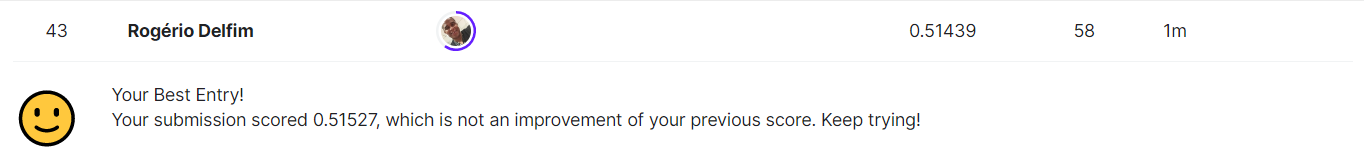

## 5.1. Distribuição e calibração

In [ ]:
cols = df_pred_tr_n3.columns
row  = int(len(cols))

fig, axs = plt.subplots(row, 2, figsize=(15, 15)) 

for i, col in enumerate(cols):     
    axs[i][0].hist(df_pred_tr_n3[col], range=(0, 1), bins=100, density=True, color='#ffd700', label='Traino')
    axs[i][0].hist(df_pred_ts_n3[col], range=(0, 1), bins=100, density=True, color='#0057b8', label='Teste')
    axs[i][0].set_title(col, fontsize=16)
    axs[i][0].legend()

    CalibrationDisplay.from_predictions(y, df_pred_tr_n3[col], ax=axs[i][1], n_bins=20, strategy='quantile', color='b')
    axs[i][1].set_title('Probability calibration')
    axs[i][1].set_xlabel('')
    axs[i][1].set_ylabel('')
        
plt.suptitle('Distribuição e calibração dos modelos', fontsize=20)
plt.tight_layout(pad=3.0);

utility.free_gpu_cache()

In [ ]:
plt.figure(figsize=(9,5))
_ = df_pred_tr_n3.copy() 
_[target] = y
feature_corr = \
    utility.graf_feature_corr(df_         = _,                             
                              annot_      = True, 
                              threshold_  = .8, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = True, 
                              method_     = 'spearman')

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
   
Observamos que a distribuição dos datasets(treino/teste) seguem a mesma distribuição, porém com a maioria das probabilidade entre 0.2 e 0.8, ainda temos um espaço para melhoria. Em relação a calibração a maioria dos modelos tem uma boa calibragem, exceto LR e XGB. <p>


</div> 

In [ ]:
cols_n3 = ['RForest', 'XGB', 'LGBM', 'HBoosting', 'LR' ] 
df_pred_tr_n3.columns= cols_n3
df_pred_ts_n3.columns= cols_n3
df_pred_ts_n3.head()

In [ ]:
w1 = .7
w2 = .3
name = 'nb_02_n4_19_emsable_average_RForest_LGBM_w1_{}_w2_{}.csv'.format(w1, w2)
name = 'nb_02_n4_22_emsable_average.csv'
df_submission['pred'] = df_pred_ts_n3['RForest']*w1 + df_pred_ts_n3['HBoosting']*w2
df_submission.to_csv(path+'Data/submission/'+name, index=False)
# 0.51404 - nb_02_n4_22_emsable_average.csv

<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 6. CONCLUSÃO </h1>    
</div>

<div class="alert alert-block alert-info" style="border-radius:15px">

Com esse notebook, consegui superar o score do notebook anterior, podemos destacar os seguintes pontos: <br>
    
- A remoção das variáveis irrelevantes com a utilização do <b>SelectFromModel do sklearn</b> deve efeito relevante para as previsões;
    
- As duas variáveis (PCA e cluster) criadas também ajudaram significativamente na melhoria do score;
    
- Foram criadas variáveis estatísca, mas não teve bom desempenho, sendo removido;  
        
- Foram geradas diversas previsões no segundo nível, no terceiro nível foi utilizado as previsões do segundo nível com a utilização de alguns classificadores do segundo nível, o melhor modelo fo <b>R. Forest</b>.  
   
<p style="color: black; font-family: Arial Black">PRÓXIMOS PASSOS:</p> <br>
- Ajuste de parametros; 
- Seleção de variáveis com permutação;
    
</div>